# **AudioFuse**

This notebook contains the end-to-end implementation of our proposed **AudioFuse** and also its baseline models for comparision. We used the PhysioNet 2016 Challenge dataset (Heart Sound Classification/Abnormality Detection) to implement it. The audio files were converted to Spectrograms and Scalograms in a separate Preprocessing script (available in the same GitHub Repository).

## **Imports**

In [ ]:
# File and Path Management
import os
import pandas as pd
import numpy as np

import librosa

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import mixed_precision

# Metrics
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_auc_score,
    roc_curve,
    matthews_corrcoef,
    cohen_kappa_score
)

# Enabling mixed precision for a significant speed boost on compatible GPUs
mixed_precision.set_global_policy('mixed_float16')

# Ensuring reproducible results
def set_seed(seed=42):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

set_seed(42)

## **Configuration**

In [ ]:
class Config:
    # --- DATASET ---

    # For PhysioNet Heart Sound
    METADATA_TRAIN_CSV = "/content/drive/MyDrive/Multimodal Audio Fusion/Heart Sounds_train.csv"
    METADATA_TEST_CSV = "/content/drive/MyDrive/Multimodal Audio Fusion/Heart Sounds_test.csv"

    # --- Image/Input Settings ---
    IMG_SIZE = 224
    IN_CHANS = 1 # Each input stream is single-channel

    # --- Custom ViT Model Settings ---
    PATCH_SIZE = 16
    PROJECTION_DIM = 192
    NUM_HEADS = 8
    TRANSFORMER_LAYERS = 6
    MLP_UNITS = [PROJECTION_DIM * 2, PROJECTION_DIM]
    DROPOUT_RATE = 0.2

    # --- Waveform Settings ---
    WAVEFORM_LENGTH_SECONDS = 5

    # --- Training Settings ---
    BATCH_SIZE = 256
    EPOCHS = 200
    LEARNING_RATE = 3e-4
    WEIGHT_DECAY = 1e-4
    VAL_SPLIT_SIZE = 0.2
    RANDOM_STATE = 42

CONFIG = Config()

## **Data Loading & Splitting**

In [ ]:
# ================================================================
# Block: Data Setup (Unzipping and Loading)
# ================================================================

import zipfile
import os
from sklearn.model_selection import train_test_split

# --- 1. Defining Paths to Zip Files and Local Directories ---

# Paths to the zip files in my Google Drive
PROCESSED_ZIP_PATH = "/content/drive/MyDrive/Multimodal Audio Fusion/Physionet_processed_images"
ORIGINAL_ZIP_PATH = "/content/drive/MyDrive/Multimodal Audio Fusion/PhysioNet Heart Sound Classification.zip"

# Local directories where data will be unzipped.
LOCAL_PROCESSED_ROOT = "/content/drive/MyDrive/Multimodal Audio Fusion/Physionet_processed_images"
LOCAL_ORIGINAL_ROOT = "/content/physionet_data/"

# # --- 2. Unzipping the Processed .npy Data ---   [This step wasn't needed as I loaded the unzipped images directly from Drive]
# print(f"Unzipping pre-processed .npy data...")
# if not os.path.exists(LOCAL_PROCESSED_ROOT):
#     with zipfile.ZipFile(PROCESSED_ZIP_PATH, 'r') as zip_ref:
#         # Unzipping to the root to match the absolute paths in the CSV
#         zip_ref.extractall("/")
#     print("Processed data unzipped successfully.")
# else:
#     print("Processed data directory already exists.")

# --- 3. Unzipping the Original .wav Data (Raw Audio Files) ---
print(f"Unzipping original .wav data...")
if not os.path.exists(LOCAL_ORIGINAL_ROOT):
    with zipfile.ZipFile(ORIGINAL_ZIP_PATH, 'r') as zip_ref:
        zip_ref.extractall(LOCAL_ORIGINAL_ROOT)
    print("Original data unzipped successfully.")
else:
    print("Original data directory already exists.")


# --- 4. Loading Metadata ---
print("\nLoading pre-processed data metadata...")

try:
    train_df = pd.read_csv(CONFIG.METADATA_TRAIN_CSV)
    val_df = pd.read_csv(CONFIG.METADATA_TEST_CSV)
    print("Loaded pre-defined train and validation sets.")

    # A small check to make sure the files actually exist after unzipping
    assert os.path.exists(train_df.iloc[0]['filepath']), f"WAV file not found at: {train_df.iloc[0]['filepath']}"
    assert os.path.exists(train_df.iloc[0]['npy_filepath']), f"NPY file not found at: {train_df.iloc[0]['npy_filepath']}"
    print("File paths in CSVs are valid.")

except AttributeError:
    # This block is for datasets with a single metadata CSV that needs to be split
    print("Single metadata file found. Creating a new train/validation split.")
    # (This part of the code will not run for PhysioNet, but I kept it for flexibility)
    full_df = pd.read_csv(CONFIG.METADATA_CSV)
    full_df.dropna(subset=['npy_filepath'], inplace=True)
    train_df, val_df = train_test_split(
        full_df, test_size=CONFIG.VAL_SPLIT_SIZE,
        random_state=CONFIG.RANDOM_STATE, stratify=full_df['label']
    )

# --- 5. Final Check ---
print(f"\nTraining set size: {len(train_df)}")
print(f"Validation set size: {len(val_df)}")
print("\nTraining DataFrame head:")
print(train_df.head())

Unzipping original .wav data...
Original data unzipped successfully.

Loading pre-processed data metadata...
Loaded pre-defined train and validation sets.
File paths in CSVs are valid.

Training set size: 2939
Validation set size: 301

Training DataFrame head:
  filename  label                                      filepath  \
0    f0001      0  /content/physionet_data/training-f/f0001.wav   
1    f0002      0  /content/physionet_data/training-f/f0002.wav   
2    f0003      1  /content/physionet_data/training-f/f0003.wav   
3    f0004      0  /content/physionet_data/training-f/f0004.wav   
4    f0005      0  /content/physionet_data/training-f/f0005.wav   

                                        npy_filepath  
0  /content/drive/MyDrive/Multimodal Audio Fusion...  
1  /content/drive/MyDrive/Multimodal Audio Fusion...  
2  /content/drive/MyDrive/Multimodal Audio Fusion...  
3  /content/drive/MyDrive/Multimodal Audio Fusion...  
4  /content/drive/MyDrive/Multimodal Audio Fusion...  


In [ ]:
# ================================================================
# Calculating Class Weights to Handle Imbalance
# ================================================================
from sklearn.utils import class_weight

train_labels = train_df['label'].values

class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels),
    y=train_labels
)

# Keras expects a dictionary mapping class indices to their weights
class_weight_dict = dict(enumerate(class_weights))

print("Calculated Class Weights:")
print(class_weight_dict)

Class Imbalance Detected. Calculated Class Weights:
{0: np.float64(0.605979381443299), 1: np.float64(2.8589494163424125)}


## **Fast Data Pipeline**

In [ ]:
# ================================================================
# Block 4: Fast Data Pipeline (Spectrogram + Waveform)
# ================================================================

# --- We now need the original .wav filepaths from the dataframe ---

WAVEFORM_MAX_LEN = int(CONFIG.WAVEFORM_LENGTH_SECONDS * 22050) # Using a typical sample rate (Always used this :3)

def load_spec_and_waveform(npy_path, wav_path, label):
    # --- Part 1: Loading Spectrogram from .npy file ---
    def _load_npy(path):
        # Loading the pre-computed 2-channel numpy array (Spectrogram and Scalogram)
        full_image = np.load(path.numpy().decode('utf-8'))
        # Slicing to get only the first channel (spectrogram)
        return full_image[:, :, 0:1] # Shape becomes (H, W, 1)

    [spec_image] = tf.py_function(_load_npy, [npy_path], [tf.float32])
    spec_image.set_shape((CONFIG.IMG_SIZE, CONFIG.IMG_SIZE, CONFIG.IN_CHANS))

    # --- Part 2: Loading and Processing Waveform from .wav file ---
    def _load_wav(path):
        path_str = path.numpy().decode('utf-8')
        wav, _ = librosa.load(path_str, sr=22050, mono=True)
        # Padding or truncating
        if len(wav) > WAVEFORM_MAX_LEN:
            wav = wav[:WAVEFORM_MAX_LEN]
        else:
            wav = np.pad(wav, (0, WAVEFORM_MAX_LEN - len(wav)), 'constant')
        return wav

    [waveform] = tf.py_function(_load_wav, [wav_path], [tf.float32])
    waveform.set_shape([WAVEFORM_MAX_LEN])

    label.set_shape([])

    # Returning a dictionary with keys matching the model's Input layers
    return {"spec_input": spec_image, "wave_input": waveform}, label

# --- Creating the tf.data.Dataset objects using the new function ---
def create_hybrid_dataset(df):
    # We now need to pass THREE columns to from_tensor_slices
    dataset = tf.data.Dataset.from_tensor_slices(
        (df['npy_filepath'].values, df['filepath'].values, df['label'].values)
    )
    dataset = dataset.map(load_spec_and_waveform, num_parallel_calls=tf.data.AUTOTUNE)
    return dataset

def configure_for_performance(ds, shuffle=False):
    if shuffle:
        ds = ds.shuffle(buffer_size=1000)
    ds = ds.batch(CONFIG.BATCH_SIZE)
    ds = ds.prefetch(buffer_size=tf.data.AUTOTUNE)
    return ds

train_ds = configure_for_performance(create_hybrid_dataset(train_df), shuffle=True)
val_ds = configure_for_performance(create_hybrid_dataset(val_df))

print("\nHybrid Spectrogram-Waveform Data pipeline ready.")

# Verifying the output shape of a batch
for data, labels in train_ds.take(1):
    print(f"Data batch is a dictionary with keys: {data.keys()}")
    print(f"Spectrogram batch shape: {data['spec_input'].shape}")
    print(f"Waveform batch shape: {data['wave_input'].shape}")
    print(f"Labels batch shape: {labels.shape}")


Hybrid Spectrogram-Waveform Data pipeline ready.
Data batch is a dictionary with keys: dict_keys(['spec_input', 'wave_input'])
Spectrogram batch shape: (256, 224, 224, 1)
Waveform batch shape: (256, 110250)
Labels batch shape: (256,)


## **Model Building**

In [ ]:
# ================================================================
# Block 5: Model Building (Spectrogram-Waveform Fusion)
# ================================================================

@tf.keras.utils.register_keras_serializable()
class PatchEmbed(layers.Layer):
    def __init__(self, patch_size, projection_dim, **kwargs):
        super().__init__(**kwargs)
        self.patch_size = patch_size
        self.projection_dim = projection_dim
        self.proj = layers.Conv2D(filters=projection_dim, kernel_size=patch_size, strides=patch_size, padding="VALID")
    def call(self, images):
        x = self.proj(images)
        return layers.Reshape((-1, x.shape[-1]))(x)
    def get_config(self):
        config = super().get_config()
        config.update({"patch_size": self.patch_size, "projection_dim": self.projection_dim})
        return config

# --- Hybrid Fusion Model ---
def create_spec_wave_fusion_vit(num_classes):
    # --- 1. Defining Two Separate Inputs ---
    spec_input = layers.Input(shape=(CONFIG.IMG_SIZE, CONFIG.IMG_SIZE, CONFIG.IN_CHANS), name="spec_input")
    wave_input = layers.Input(shape=(WAVEFORM_MAX_LEN,), name="wave_input")

    # ================================================================
    # Branch 1: The Custom 2D Vision Transformer
    # ================================================================
    print("Building Spectrogram ViT Branch...")

    spec_patch_embed = PatchEmbed(CONFIG.PATCH_SIZE, CONFIG.PROJECTION_DIM, name="spec_patch_embed")(spec_input)
    num_patches = (CONFIG.IMG_SIZE // CONFIG.PATCH_SIZE) ** 2
    spec_pos_embedding = layers.Embedding(input_dim=num_patches, output_dim=CONFIG.PROJECTION_DIM, name="spec_pos_embedding")
    positions = tf.range(start=0, limit=num_patches, delta=1)
    spec_encoded = spec_patch_embed + spec_pos_embedding(positions)

    for i in range(CONFIG.TRANSFORMER_LAYERS):
        x1 = layers.LayerNormalization(epsilon=1e-6)(spec_encoded)
        attn = layers.MultiHeadAttention(num_heads=CONFIG.NUM_HEADS, key_dim=CONFIG.PROJECTION_DIM // CONFIG.NUM_HEADS, dropout=CONFIG.DROPOUT_RATE)(x1, x1)
        x2 = layers.Add()([attn, spec_encoded])
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        for units in CONFIG.MLP_UNITS:
            x3 = layers.Dense(units, activation=tf.nn.gelu)(x3)
            x3 = layers.Dropout(CONFIG.DROPOUT_RATE)(x3)
        spec_encoded = layers.Add()([x3, x2])

    spec_representation = layers.LayerNormalization(epsilon=1e-6)(spec_encoded)
    spec_features = layers.GlobalAveragePooling1D(name="spec_gap")(spec_representation)

    # ================================================================
    # Branch 2: The 1D Waveform CNN
    # ================================================================
    print("Building Waveform CNN Branch...")
    # Reshaping waveform to add a "channels" dimension for Conv1D
    wave_reshaped = layers.Reshape((-1, 1))(wave_input)

    x_1d = layers.Conv1D(64, kernel_size=16, strides=4, activation='relu', padding='same')(wave_reshaped)
    x_1d = layers.BatchNormalization()(x_1d)
    x_1d = layers.MaxPooling1D(pool_size=4)(x_1d)

    x_1d = layers.Conv1D(128, kernel_size=16, strides=4, activation='relu', padding='same')(x_1d)
    x_1d = layers.BatchNormalization()(x_1d)
    x_1d = layers.MaxPooling1D(pool_size=4)(x_1d)

    x_1d = layers.Conv1D(256, kernel_size=16, strides=4, activation='relu', padding='same')(x_1d)
    x_1d = layers.BatchNormalization()(x_1d)

    wave_pooled = layers.GlobalAveragePooling1D()(x_1d)

    # A dense layer to summarize the waveform info into a small, powerful vector
    wave_features = layers.Dense(64, activation='relu', name="waveform_funnel")(wave_pooled)

    # ================================================================
    # 3. Late Fusion and Final Classifier
    # ================================================================
    print("Building Fusion Head...")
    fused_features = layers.Concatenate(axis=-1, name="fusion_concat")([spec_features, wave_features])

    x = layers.Dense(CONFIG.PROJECTION_DIM, activation='relu', name="fusion_dense_1")(fused_features)
    x = layers.Dropout(0.5)(x) # Using a higher dropout in the head to prevent overfitting

    if num_classes == 2:
        output_activation, output_units = None, 1
    else:
        output_activation, output_units = "softmax", num_classes

    outputs = layers.Dense(output_units, activation=output_activation, dtype='float32', name="predictions")(x)

    model = keras.Model(inputs=[spec_input, wave_input], outputs=outputs)
    return model

# --- Instantiating the new model ---
NUM_CLASSES = train_df['label'].nunique()
model = create_spec_wave_fusion_vit(num_classes=NUM_CLASSES)
model.summary()

Building Spectrogram ViT Branch...
Building Waveform CNN Branch...
Building Fusion Head...


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ spec_input          │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spec_patch_embed    │ (None, 196, 192)  │     49,344 │ spec_input[0][0]  │
│ (PatchEmbed)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 196, 192)  │          0 │ spec_patch_embed… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 196, 192)  │        384 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 196, 192)  │    148,224 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 196, 192)  │          0 │ multi_head_atten… │
│                     │                   │            │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 196, 192)  │        384 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 196, 384)  │     74,112 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 196, 384)  │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 196, 192)  │     73,920 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 196, 192)  │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 196, 192)  │          0 │ dropout_2[0][0],  │
│                     │                   │            │ add_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 196, 192)  │        384 │ add_2[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 196, 192)  │    148,224 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 196, 192)  │          0 │ multi_head_atten… │
│                     │                   │            │ add_2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 196, 192)  │        384 │ add_3[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 196, 384)  │     74,112 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 196, 384)  │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 196, 192)  │     73,920 │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 2,556,481 (9.75 MB)

 Trainable params: 2,555,585 (9.75 MB)

 Non-trainable params: 896 (3.50 KB)

## **Model Training**

In [ ]:
# ================================================================
# Block 6: Model Training
# ================================================================

def configure_for_performance(ds, shuffle=False):
    if shuffle:
        ds = ds.shuffle(buffer_size=1000)
    ds = ds.repeat() # Makes the dataset loop indefinitely
    ds = ds.batch(CONFIG.BATCH_SIZE)
    ds = ds.prefetch(buffer_size=tf.data.AUTOTUNE)
    return ds

# Re-creating the datasets with the corrected function
train_ds = configure_for_performance(create_hybrid_dataset(train_df), shuffle=True)
val_ds = configure_for_performance(create_hybrid_dataset(val_df))
print("Data pipelines re-configured with .repeat() for multi-epoch training.")

# --- Selecting Loss and Metrics ---
if NUM_CLASSES == 2:
    loss = keras.losses.BinaryCrossentropy(from_logits=True)
    metrics = [keras.metrics.BinaryAccuracy(name="accuracy"), keras.metrics.AUC(name="auc")]
else:
    loss = keras.losses.SparseCategoricalCrossentropy()
    metrics = [keras.metrics.SparseCategoricalAccuracy(name="accuracy")]

# --- Compiling the model ---
optimizer = tf.keras.optimizers.AdamW(learning_rate=CONFIG.LEARNING_RATE, weight_decay=CONFIG.WEIGHT_DECAY)
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

# --- Defining Callbacks ---
checkpoint_filepath = "best_model_spec_wave_fusion.keras"
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath, save_best_only=True, monitor='val_accuracy', mode='max')
early_stopping_callback = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=30, restore_best_weights=True)

# --- Adding steps_per_epoch and validation_steps to model.fit ---
import math

steps_per_epoch = math.ceil(len(train_df) / CONFIG.BATCH_SIZE)
validation_steps = math.ceil(len(val_df) / CONFIG.BATCH_SIZE)

print(f"\nTraining with {steps_per_epoch} steps per epoch and {validation_steps} validation steps.")

# --- Training the model ---
print("\nStarting model training...")
history = model.fit(
    train_ds,
    epochs=CONFIG.EPOCHS,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_ds,
    validation_steps=validation_steps,
    callbacks=[model_checkpoint_callback, early_stopping_callback],
    class_weight=class_weight_dict
)
print("Training complete.")

Data pipelines re-configured with .repeat() for multi-epoch training.

Training with 23 steps per epoch and 3 validation steps.

Starting model training...
Epoch 1/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 146s 4s/step - accuracy: 0.6607 - auc: 0.6680 - loss: 0.6774 - val_accuracy: 0.4974 - val_auc: 0.5000 - val_loss: 0.8853
Epoch 2/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 10s 439ms/step - accuracy: 0.8346 - auc: 0.8251 - loss: 0.4773 - val_accuracy: 0.4974 - val_auc: 0.5000 - val_loss: 0.8102
Epoch 3/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 16s 711ms/step - accuracy: 0.8455 - auc: 0.8631 - loss: 0.4337 - val_accuracy: 0.4974 - val_auc: 0.5000 - val_loss: 0.7827
Epoch 4/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 16s 722ms/step - accuracy: 0.8569 - auc: 0.8529 - loss: 0.4311 - val_accuracy: 0.4974 - val_auc: 0.5000 - val_loss: 0.7053
Epoch 5/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 16s 725ms/step - accuracy: 0.8099 - auc: 0.8237 - loss: 0.4910 - val_accuracy: 0.4974 - val_auc: 0.5000 - val_loss: 0.7240
Epoch 6/200
23/23 ━━━━━━━━━━━━━━━━━━

## **Evaluation**


Loading best model for final evaluation...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:421: UserWarning: `build()` was called on layer 'spec_patch_embed', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


Creating a finite validation dataset for evaluation...
Generating predictions on the validation set...
3/3 ━━━━━━━━━━━━━━━━━━━━ 18s 6s/step
Extracting true labels...

Plotting training and validation history...


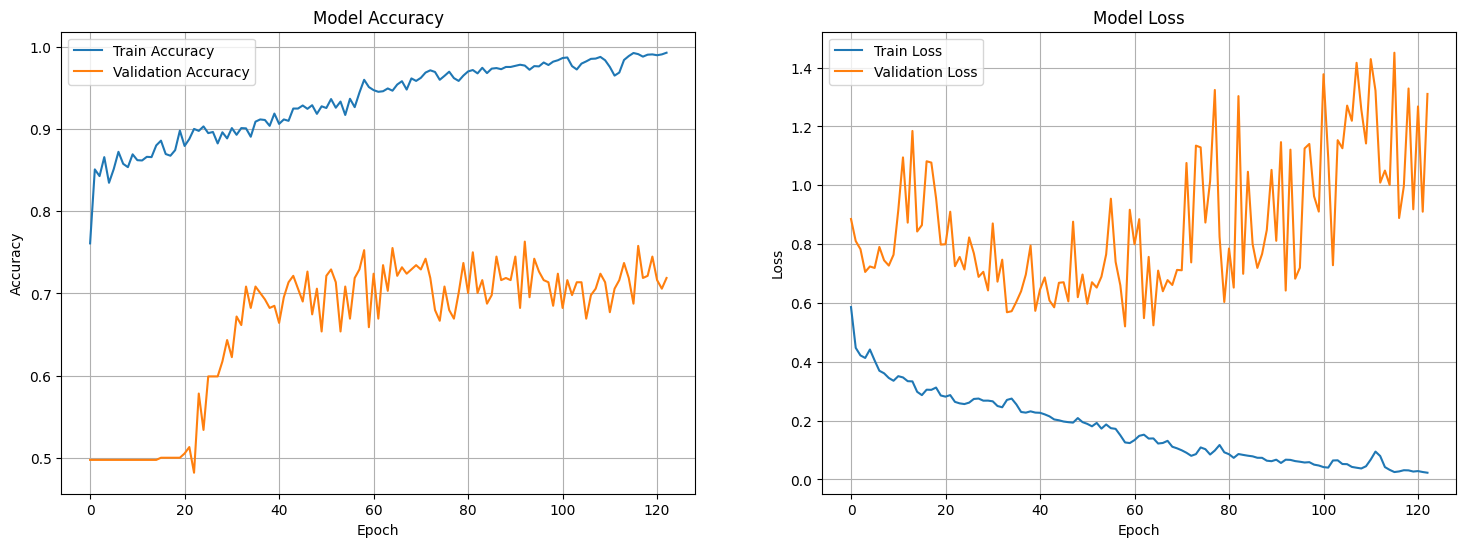


Calculating key performance metrics...
Matthews Correlation Coefficient: 0.5349
Cohen's Kappa Score: 0.5349
AUC-ROC Score: 0.8697

Classification Report:
              precision    recall  f1-score   support

      Normal     0.7632    0.7733    0.7682       150
    Abnormal     0.7718    0.7616    0.7667       151

    accuracy                         0.7674       301
   macro avg     0.7675    0.7675    0.7674       301
weighted avg     0.7675    0.7674    0.7674       301


Plotting Confusion Matrix...


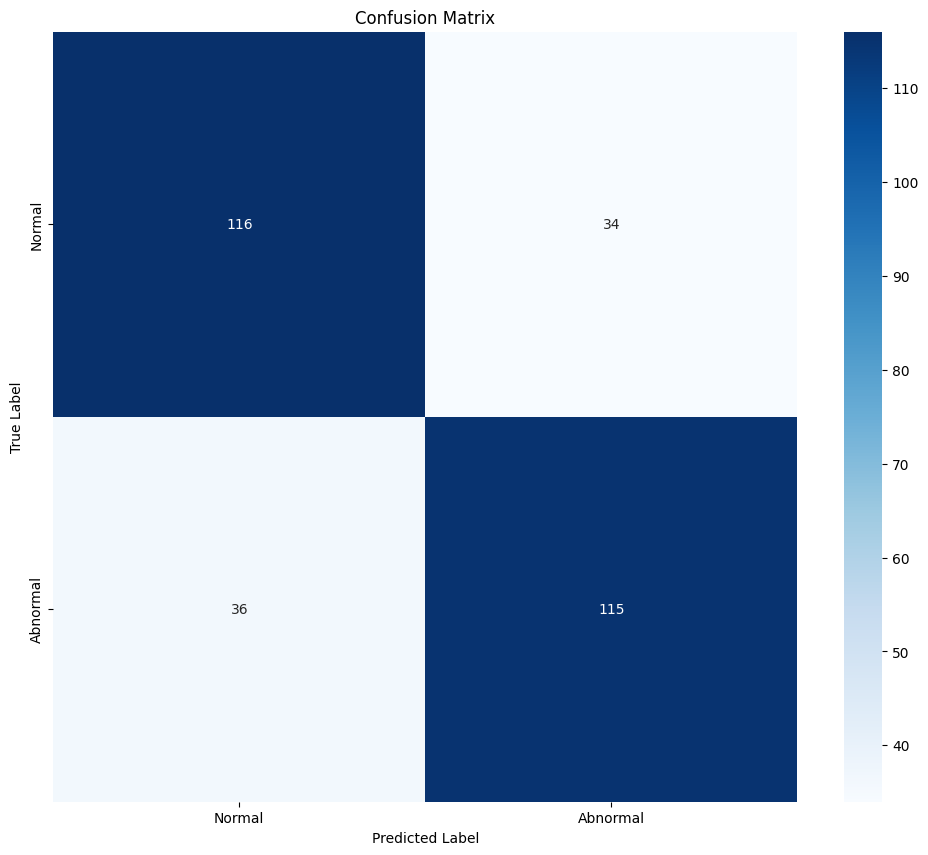


Plotting ROC Curves...


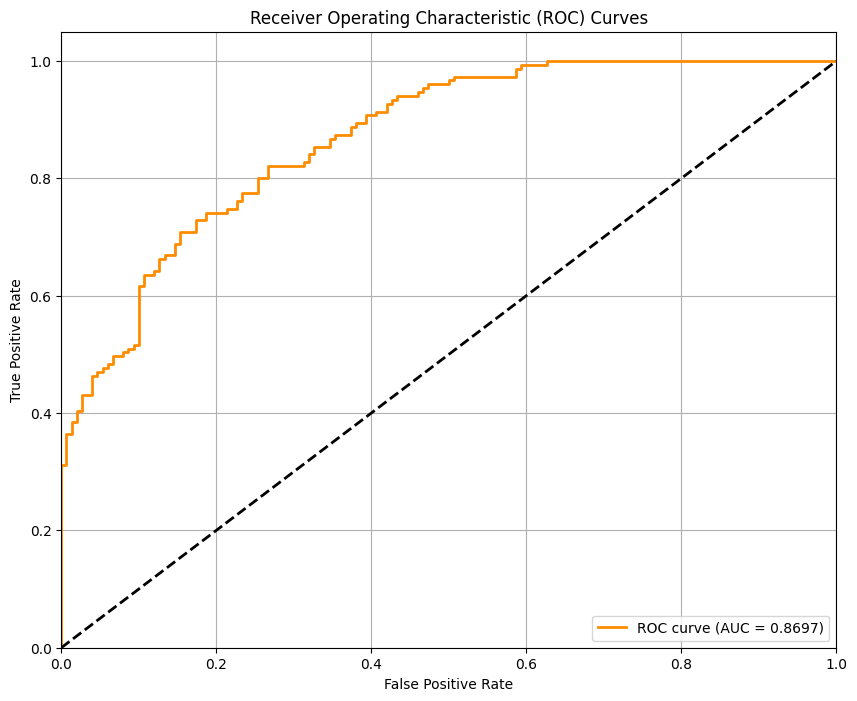

In [ ]:
# ================================================================
# Block 7: Comprehensive Evaluation
# ================================================================
from sklearn.preprocessing import label_binarize
from itertools import cycle

# --- Loading the best model ---
print("\nLoading best model for final evaluation...")
best_model = keras.models.load_model(
    checkpoint_filepath,
    custom_objects={'PatchEmbed': PatchEmbed} # Still needed for the custom layer
)

# --- Create a new, FINITE dataset for evaluation ---
# This new dataset does NOT have the .repeat() call (otherwise infinite loop .. :3).
print("Creating a finite validation dataset for evaluation...")
val_ds_eval = create_hybrid_dataset(val_df).batch(CONFIG.BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# --- Getting predictions on the finite validation set ---
print("Generating predictions on the validation set...")
predictions = best_model.predict(val_ds_eval)

# --- Getting true labels directly from the DataFrame ---
print("Extracting true labels...")
y_true = val_df['label'].values

# --- Processing predictions based on the task ---
if NUM_CLASSES == 2:
    # For binary classification, applying sigmoid to get probabilities
    y_prob = tf.nn.sigmoid(predictions).numpy().flatten()
    y_pred = (y_prob > 0.5).astype(int)
else:
    # For multi-class, softmax already gives probabilities
    y_prob = predictions
    y_pred = np.argmax(y_prob, axis=1)

# ===================================================================
# 1. Plotting Training History (Loss and Accuracy Curves)
# ===================================================================
print("\nPlotting training and validation history...")
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

ax1.plot(history.history['accuracy'], label='Train Accuracy')
ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_title('Model Accuracy')
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Epoch')
ax1.legend(loc='upper left')
ax1.grid(True)

# Plotting training & validation loss values
ax2.plot(history.history['loss'], label='Train Loss')
ax2.plot(history.history['val_loss'], label='Validation Loss')
ax2.set_title('Model Loss')
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epoch')
ax2.legend(loc='upper left')
ax2.grid(True)

plt.show()

# ===================================================================
# 2. Key Performance Metrics
# ===================================================================
print("\nCalculating key performance metrics...")

# --- Matthews Correlation Coefficient and Cohen's Kappa ---
mcc = matthews_corrcoef(y_true, y_pred)
kappa = cohen_kappa_score(y_true, y_pred)
print(f"Matthews Correlation Coefficient: {mcc:.4f}")
print(f"Cohen's Kappa Score: {kappa:.4f}")

# --- AUC-ROC Scores ---
if NUM_CLASSES == 2:
    auc_roc = roc_auc_score(y_true, y_prob)
    print(f"AUC-ROC Score: {auc_roc:.4f}")
else:
    # Using One-vs-Rest for multi-class AUC
    auc_roc_macro = roc_auc_score(y_true, y_prob, multi_class='ovr', average='macro')
    auc_roc_weighted = roc_auc_score(y_true, y_prob, multi_class='ovr', average='weighted')
    print(f"AUC-ROC (Macro Average): {auc_roc_macro:.4f}")
    print(f"AUC-ROC (Weighted Average): {auc_roc_weighted:.4f}")

# ===================================================================
# 3. Classification Report & Confusion Matrix
# ===================================================================
print("\nClassification Report:")
# Generating class names for the report if they exist
try:
    class_names = [name for name, index in sorted(class_to_id.items(), key=lambda item: item[1])]
except NameError:
    class_names = ['Normal', 'Abnormal'] if NUM_CLASSES == 2 else [f'Class {i}' for i in range(NUM_CLASSES)]

print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

print("\nPlotting Confusion Matrix...")
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# ===================================================================
# 4. ROC Curves
# ===================================================================
print("\nPlotting ROC Curves...")
plt.figure(figsize=(10, 8))

if NUM_CLASSES == 2:
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {auc_roc:.4f})')
else:
    # Binarizing the labels for multi-class ROC
    y_true_binarized = label_binarize(y_true, classes=range(NUM_CLASSES))
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 'purple', 'brown', 'pink', 'gray', 'olive'])
    for i, color in zip(range(NUM_CLASSES), colors):
        fpr, tpr, _ = roc_curve(y_true_binarized[:, i], y_prob[:, i])
        roc_auc = roc_auc_score(y_true_binarized[:, i], y_prob[:, i])
        plt.plot(fpr, tpr, color=color, lw=2,
                 label=f'ROC curve of {class_names[i]} (AUC = {roc_auc:.4f})')

# Plotting the diagonal line
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

## **XAI & Attention Rollout**

Setting up Explainable AI components for the Hybrid Model...
Loading best trained model from: best_model_spec_wave_fusion.keras
Copying weights from trained model to ViT explainer model...
ViT explainer model is ready.
Waveform CNN explainer will use layer: conv1d_2
------------------------------------------------------------
Explaining Sample 1: True Label = 1, Predicted Label = 1


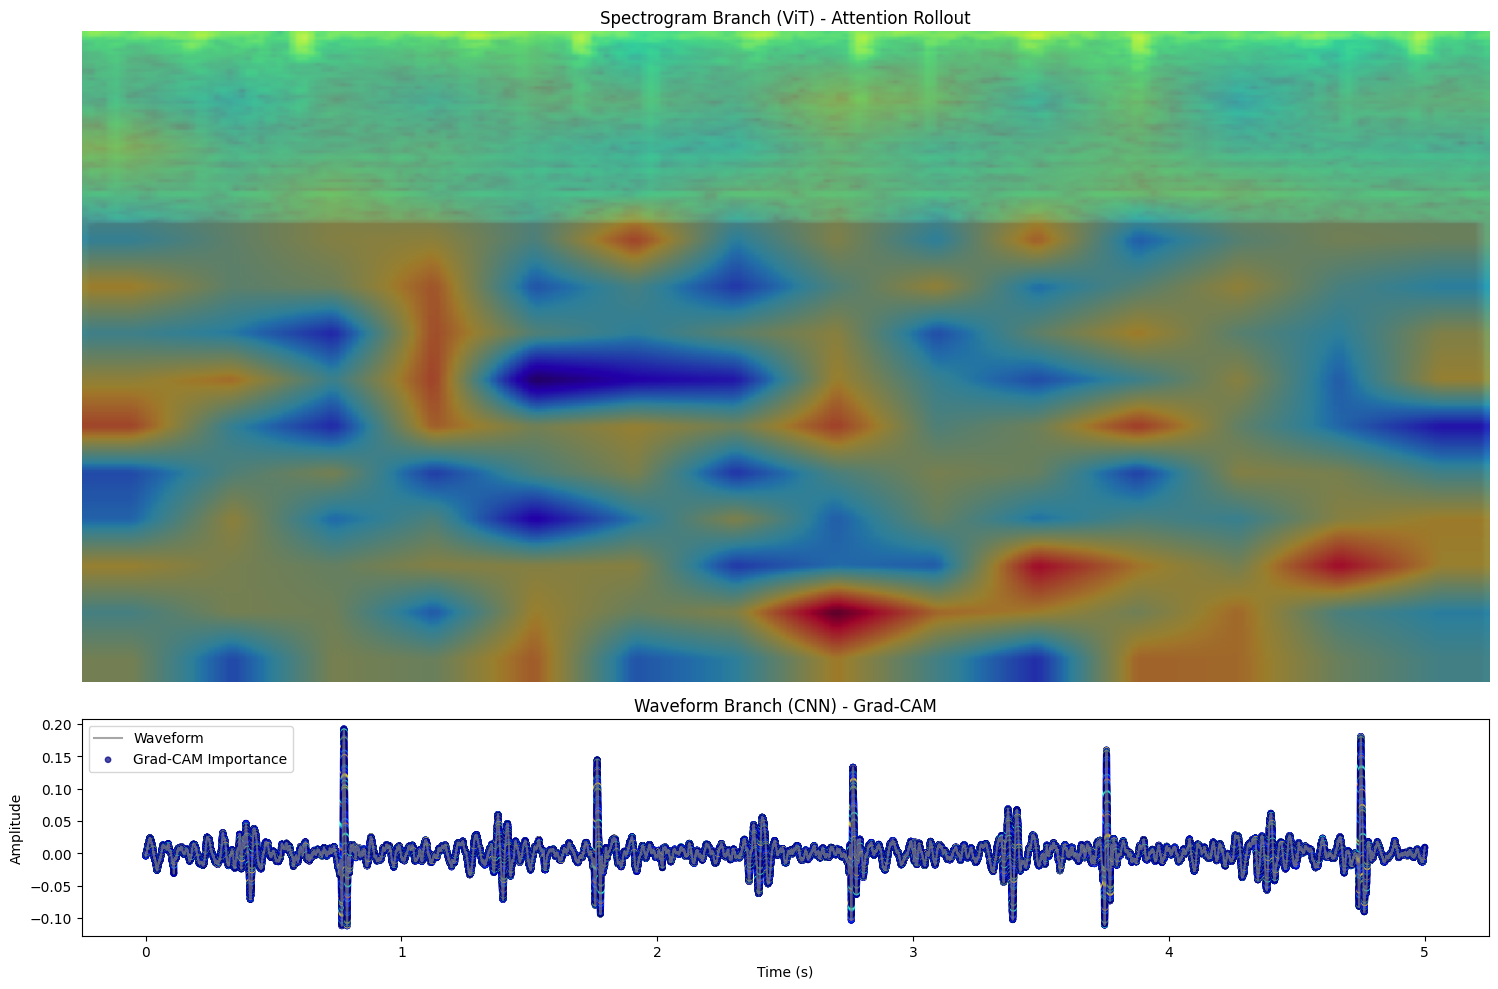

------------------------------------------------------------
Explaining Sample 2: True Label = 1, Predicted Label = 1


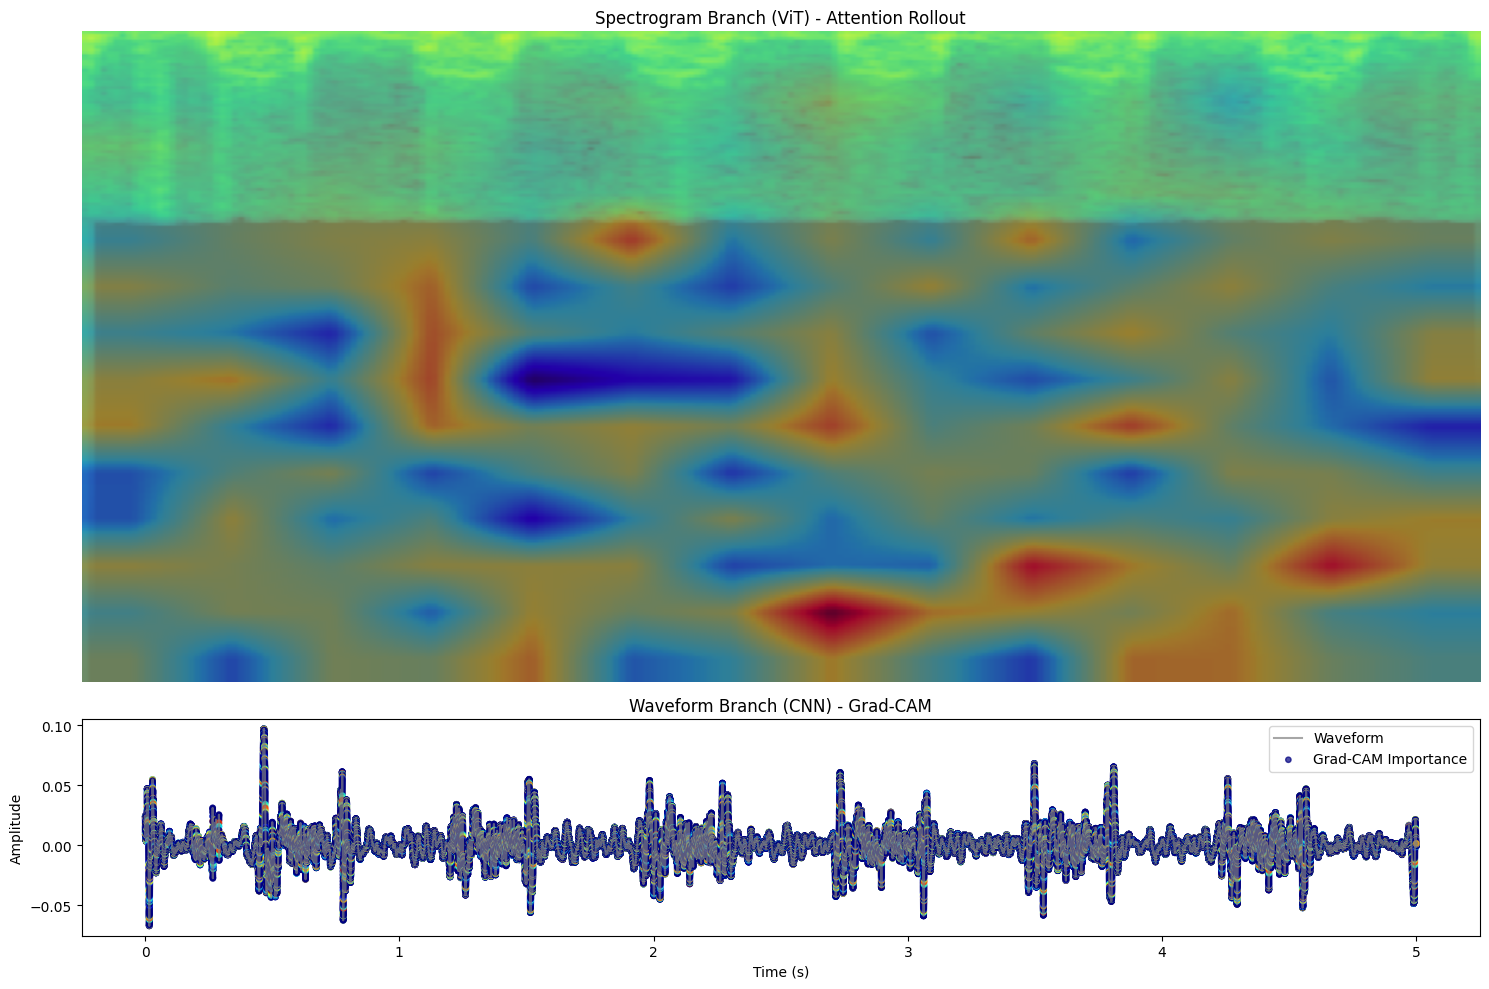

------------------------------------------------------------
Explaining Sample 3: True Label = 1, Predicted Label = 1


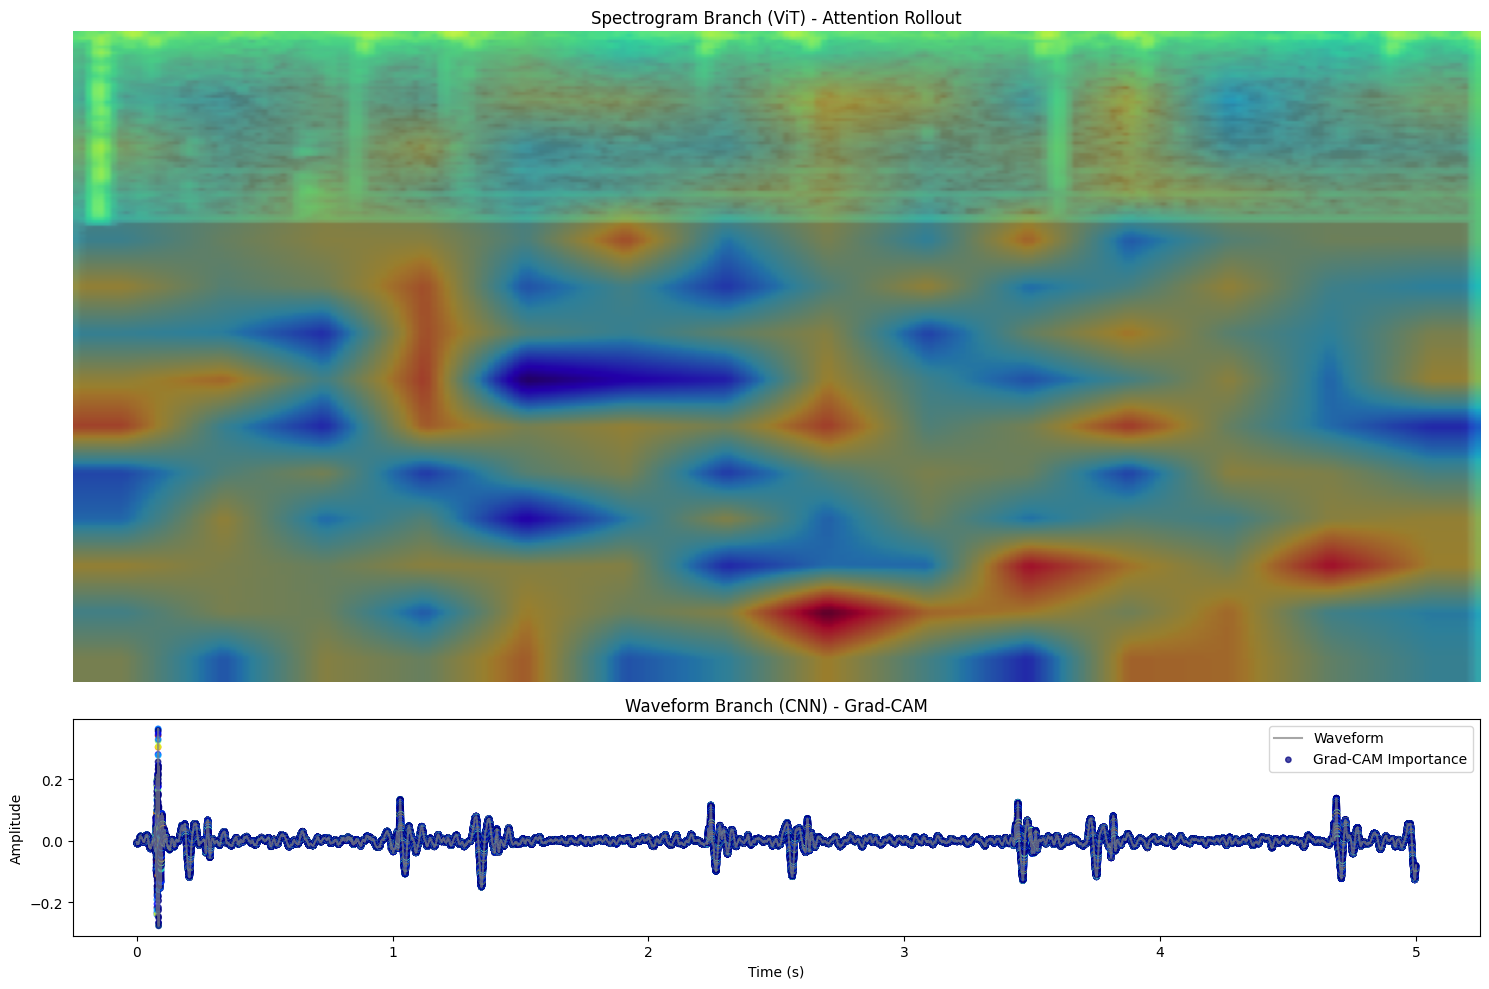


Analyzing Modality Contribution...


Analyzing Modalities:   0%|          | 0/301 [00:00<?, ?it/s]


Average Spectrogram Feature Norm: 13.2578
Average Waveform Feature Norm:  7.5156

The Spectrogram branch appears to be more influential by a factor of 1.76x.


In [ ]:
# ================================================================
# Block 8: Explainable AI for Hybrid Fusion Model
# ================================================================
import cv2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt

print("Setting up Explainable AI components for the Hybrid Model...")

# --- Part 1: Loading the Best Trained Model ---
print(f"Loading best trained model from: {checkpoint_filepath}")
best_model = keras.models.load_model(
    checkpoint_filepath,
    custom_objects={'PatchEmbed': PatchEmbed}
)

# ================================================================
# Part 2: XAI for the Spectrogram ViT Branch (Attention Rollout)
# ================================================================

# --- Step 2A: Rebuilding the Model Architecture to get Attention Scores ---
def create_vit_explainer_model():
    """
    Rebuilds the ViT branch of our hybrid model, but configures the MHA layers
    to return their attention scores as an additional output.
    """
    spec_input = layers.Input(shape=(CONFIG.IMG_SIZE, CONFIG.IMG_SIZE, CONFIG.IN_CHANS), name="spec_input")

    # Recreating the ViT branch exactly as before
    spec_patch_embed = PatchEmbed(CONFIG.PATCH_SIZE, CONFIG.PROJECTION_DIM, name="spec_patch_embed")(spec_input)
    num_patches = (CONFIG.IMG_SIZE // CONFIG.PATCH_SIZE) ** 2
    spec_pos_embedding = layers.Embedding(input_dim=num_patches, output_dim=CONFIG.PROJECTION_DIM, name="spec_pos_embedding")
    positions = tf.range(start=0, limit=num_patches, delta=1)
    spec_encoded = spec_patch_embed + spec_pos_embedding(positions)

    attention_score_outputs = [] # List to hold the score tensors

    for i in range(CONFIG.TRANSFORMER_LAYERS):
        x1 = layers.LayerNormalization(epsilon=1e-6, name=f"spec_norm1_layer_{i}")(spec_encoded)

        # Creating a new MHA layer instance with the same parameters as the original
        attn_layer = layers.MultiHeadAttention(
            num_heads=CONFIG.NUM_HEADS, key_dim=CONFIG.PROJECTION_DIM // CONFIG.NUM_HEADS,
            dropout=CONFIG.DROPOUT_RATE, name=f"spec_mha_layer_{i}"
        )

        # Calling it to get both outputs
        attention_output, attention_scores = attn_layer(x1, x1, return_attention_scores=True)
        attention_score_outputs.append(attention_scores) # Store the scores

        x2 = layers.Add(name=f"spec_add1_layer_{i}")([attention_output, spec_encoded])
        x3 = layers.LayerNormalization(epsilon=1e-6, name=f"spec_norm2_layer_{i}")(x2)
        for j, units in enumerate(CONFIG.MLP_UNITS):
            x3 = layers.Dense(units, activation=tf.nn.gelu, name=f"spec_mlp_{i}_dense_{j}")(x3)
            x3 = layers.Dropout(CONFIG.DROPOUT_RATE, name=f"spec_mlp_{i}_dropout_{j}")(x3)
        spec_encoded = layers.Add(name=f"spec_add2_layer_{i}")([x3, x2])

    # The explainer model only needs to output the attention scores
    explainer = keras.Model(inputs=spec_input, outputs=attention_score_outputs)
    return explainer

# --- Step 2B: Instantiating the Explainer and Manually Copying Weights ---
spec_explainer = create_vit_explainer_model()

print("Copying weights from trained model to ViT explainer model...")
# Iterating through layers and copying weights by name
for layer in best_model.layers:
    try:
        explainer_layer = spec_explainer.get_layer(name=layer.name)
        explainer_layer.set_weights(layer.get_weights())
    except ValueError:
        # This will happen for layers that are not in the explainer (e.g., waveform branch)
        pass
print("ViT explainer model is ready.")


# --- Step 2C: Attention Rollout Algorithm ---
def compute_attention_rollout(attention_scores_list):
    num_patches = attention_scores_list[0].shape[-1]
    rollout = np.eye(num_patches, num_patches)
    for attention_map_batch in attention_scores_list:
        attention_map = attention_map_batch[0]
        avg_head_map = np.mean(attention_map, axis=0)
        residual_map = avg_head_map + np.eye(avg_head_map.shape[0])
        residual_map = residual_map / residual_map.sum(axis=-1, keepdims=True)
        rollout = np.matmul(residual_map, rollout)
    return rollout

# ================================================================
# Part 3: XAI for the Waveform CNN Branch (Grad-CAM)
# ================================================================

# --- Step 3A: Grad-CAM Algorithm for 1D Signals ---
def make_gradcam_heatmap_1d(waveform_array, model, last_conv_layer_name, pred_index=None):
    # Creating a model that maps BOTH inputs to the last conv layer and the final prediction
    grad_model = keras.Model(
        model.inputs,
        [model.get_layer(last_conv_layer_name).output, model.output]
    )
    # Creating a dummy spectrogram input of the correct shape
    dummy_spec = tf.zeros((1, CONFIG.IMG_SIZE, CONFIG.IMG_SIZE, CONFIG.IN_CHANS), dtype=tf.float16)

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model([dummy_spec, waveform_array])
        if pred_index is None: pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1))
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / (tf.math.reduce_max(heatmap) + 1e-6)
    return heatmap.numpy()

# Finding the name of the last Conv1D layer in our trained model
last_conv_layer_name_1d = [l.name for l in best_model.layers if isinstance(l, layers.Conv1D)][-1]
print(f"Waveform CNN explainer will use layer: {last_conv_layer_name_1d}")

# ================================================================
# Part 4: Combined Visualization and Analysis Loop
# ================================================================

# --- Creating a finite, non-repeating validation set for explanation ---
val_ds_eval = create_hybrid_dataset(val_df).batch(1).prefetch(tf.data.AUTOTUNE)

for i, (data, labels) in enumerate(val_ds_eval.take(3)):
    spec_sample = data['spec_input']
    wave_sample = data['wave_input']
    true_label = labels.numpy()[0]

    pred = best_model.predict_on_batch(data)
    pred_label = np.argmax(pred[0]) if NUM_CLASSES > 2 else (tf.nn.sigmoid(pred).numpy()[0,0] > 0.5).astype(int)

    print("-" * 60)
    print(f"Explaining Sample {i+1}: True Label = {true_label}, Predicted Label = {pred_label}")

    # 1. Generating Spectrogram Attention
    attention_scores = spec_explainer.predict_on_batch(spec_sample)
    rollout_map = compute_attention_rollout(attention_scores)
    patch_importance = rollout_map.mean(axis=0)
    num_patches_side = int(np.sqrt(len(patch_importance)))
    heatmap_2d = patch_importance.reshape(num_patches_side, num_patches_side)
    heatmap_2d_resized = cv2.resize(heatmap_2d / heatmap_2d.max(), (CONFIG.IMG_SIZE, CONFIG.IMG_SIZE))

    # 2. Generating Waveform Grad-CAM
    heatmap_1d = make_gradcam_heatmap_1d(wave_sample, best_model, last_conv_layer_name_1d)

    # 3. Plotting Both Explanations
    fig, axs = plt.subplots(2, 1, figsize=(15, 10), gridspec_kw={'height_ratios': [3, 1]})
    axs[0].imshow(spec_sample[0], cmap='viridis', aspect='auto'); axs[0].imshow(heatmap_2d_resized, cmap='jet', alpha=0.5, aspect='auto')
    axs[0].set_title("Spectrogram Branch (ViT) - Attention Rollout"); axs[0].axis('off')

    waveform_to_plot = wave_sample[0].numpy()
    time_axis = np.arange(len(waveform_to_plot)) / 22050.0
    heatmap_1d_resized = np.resize(heatmap_1d, waveform_to_plot.shape)

    axs[1].plot(time_axis, waveform_to_plot, color='gray', alpha=0.7, label='Waveform')
    axs[1].scatter(time_axis, waveform_to_plot, c=heatmap_1d_resized, cmap='jet', s=15, alpha=0.7, label='Grad-CAM Importance')
    axs[1].set_title("Waveform Branch (CNN) - Grad-CAM"); axs[1].set_xlabel("Time (s)"); axs[1].set_ylabel("Amplitude")
    axs[1].legend()
    plt.tight_layout(); plt.show()

# ================================================================
# Part 4: Analyzing Modality Contribution
# ================================================================
print("\n" + "=" * 50)
print("Analyzing Modality Contribution...")

spec_branch_output = best_model.get_layer("spec_gap").output
wave_branch_output = best_model.get_layer("waveform_funnel").output

modality_model = keras.Model(inputs=best_model.inputs, outputs=[spec_branch_output, wave_branch_output])
spec_norms, wave_norms = [], []

for data, labels in tqdm(val_ds_eval, desc="Analyzing Modalities"):
    spec_features, wave_features = modality_model.predict_on_batch(data)
    spec_norms.extend(np.linalg.norm(spec_features, axis=-1))
    wave_norms.extend(np.linalg.norm(wave_features, axis=-1))

avg_spec_norm = np.mean(spec_norms)
avg_wave_norm = np.mean(wave_norms)

print(f"\nAverage Spectrogram Feature Norm: {avg_spec_norm:.4f}")
print(f"Average Waveform Feature Norm:  {avg_wave_norm:.4f}")

if avg_spec_norm > avg_wave_norm:
    ratio = avg_spec_norm / avg_wave_norm
    print(f"\nThe Spectrogram branch appears to be more influential by a factor of {ratio:.2f}x.")
else:
    ratio = avg_wave_norm / avg_spec_norm
    print(f"\nThe Waveform branch appears to be more influential by a factor of {ratio:.2f}x.")

# **Spectrogram-Only Baseline**

# **Data Preparation**

In [ ]:
print("Loading pre-processed metadata for Spectrogram-Only baseline...")
train_df = pd.read_csv(CONFIG.METADATA_TRAIN_CSV)
val_df = pd.read_csv(CONFIG.METADATA_TEST_CSV)

print(f"Training set size: {len(train_df)}")
print(f"Validation set size: {len(val_df)}")


# --- Modified Data Pipeline Function ---
# This function loads the 2-channel .npy file but only returns the first channel.
def load_and_extract_spectrogram(npy_path, label):
    def _load_and_extract(npy_path):
        # Loading the pre-computed 2-channel numpy array
        full_image = np.load(npy_path.numpy())
        # Slicing the array to get only the first channel (spectrogram)
        return full_image[:, :, 0:1] # Shape becomes (H, W, 1)

    [image] = tf.py_function(_load_and_extract, [npy_path], [tf.float32])

    # Setting the shape for the single-channel image
    image.set_shape((CONFIG.IMG_SIZE, CONFIG.IMG_SIZE, CONFIG.IN_CHANS))
    label.set_shape([])

    # Returning a simple (image, label) tuple, not a dictionary
    return image, label


# --- Creating the tf.data.Dataset objects using the new function ---
def create_fast_dataset(df):
    # Ensuring we are using the correct column name from our fusion metadata CSV
    dataset = tf.data.Dataset.from_tensor_slices((df['npy_filepath'].values, df['label'].values))
    dataset = dataset.map(load_and_extract_spectrogram, num_parallel_calls=tf.data.AUTOTUNE)
    return dataset

def configure_for_performance(ds, shuffle=False):
    if shuffle:
        ds = ds.shuffle(buffer_size=1000)
    ds = ds.batch(CONFIG.BATCH_SIZE)
    ds = ds.prefetch(buffer_size=tf.data.AUTOTUNE)
    return ds

train_ds = configure_for_performance(create_fast_dataset(train_df), shuffle=True)
val_ds = configure_for_performance(create_fast_dataset(val_df))


print("\nSpectrogram-Only Data pipeline ready.")
# Verifying the output shape of a batch
for images, labels in train_ds.take(1):
    print(f"Images batch shape: {images.shape}") # Should now be [batch_size, H, W, 1]
    print(f"Labels batch shape: {labels.shape}")

Loading pre-processed metadata for Spectrogram-Only baseline...
Training set size: 2939
Validation set size: 301

Spectrogram-Only Data pipeline ready.
Images batch shape: (256, 224, 224, 1)
Labels batch shape: (256,)


## **Model Building**

In [ ]:
# Enabling mixed precision for speed boost
mixed_precision.set_global_policy('mixed_float16')
print(f"Mixed precision enabled: {mixed_precision.global_policy().name}")

@tf.keras.utils.register_keras_serializable()
class PatchEmbed(layers.Layer):
    """Efficiently create and project patches using a Conv2D layer."""
    def __init__(self, patch_size, projection_dim, **kwargs):
        super().__init__(**kwargs)
        self.patch_size = patch_size
        self.projection_dim = projection_dim
        self.proj = layers.Conv2D(filters=projection_dim, kernel_size=patch_size, strides=patch_size, padding="VALID")
    def call(self, images):
        x = self.proj(images)
        return layers.Reshape((-1, x.shape[-1]))(x)
    def get_config(self):
        config = super().get_config()
        config.update({"patch_size": self.patch_size, "projection_dim": self.projection_dim})
        return config

# --- The Spectrogram-Only ViT Architecture ---
def create_spectrogram_vit(num_classes):
    # A single input for the spectrogram
    inputs = layers.Input(shape=(CONFIG.IMG_SIZE, CONFIG.IMG_SIZE, CONFIG.IN_CHANS), name="spectrogram_input")

    # Creating and encoding patches
    patches = PatchEmbed(CONFIG.PATCH_SIZE, CONFIG.PROJECTION_DIM)(inputs)
    num_patches = (CONFIG.IMG_SIZE // CONFIG.PATCH_SIZE) ** 2
    pos_embedding_layer = layers.Embedding(input_dim=num_patches, output_dim=CONFIG.PROJECTION_DIM)
    positions = tf.range(start=0, limit=num_patches, delta=1)
    encoded_patches = patches + pos_embedding_layer(positions)

    # Transformer Encoder blocks
    for _ in range(CONFIG.TRANSFORMER_LAYERS):
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        attention_output = layers.MultiHeadAttention(
            num_heads=CONFIG.NUM_HEADS, key_dim=CONFIG.PROJECTION_DIM // CONFIG.NUM_HEADS, dropout=CONFIG.DROPOUT_RATE
        )(x1, x1)
        x2 = layers.Add()([attention_output, encoded_patches])

        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        for units in CONFIG.MLP_UNITS:
            x3 = layers.Dense(units, activation=tf.nn.gelu)(x3)
            x3 = layers.Dropout(CONFIG.DROPOUT_RATE + 0.1)(x3)

        encoded_patches = layers.Add()([x3, x2])

    # Classifier Head
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    pooled_output = layers.GlobalAveragePooling1D()(representation)

    if num_classes == 2:
        output_activation, output_units = None, 1
    else:
        output_activation, output_units = "softmax", num_classes

    outputs = layers.Dense(output_units, activation=output_activation, dtype='float32')(pooled_output)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

# Instantiating the new, simpler model
NUM_CLASSES = train_df['label'].nunique()
model = create_spectrogram_vit(num_classes=NUM_CLASSES)
model.summary()

Mixed precision enabled: mixed_float16


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ spectrogram_input   │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ patch_embed         │ (None, 196, 192)  │     49,344 │ spectrogram_inpu… │
│ (PatchEmbed)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 196, 192)  │          0 │ patch_embed[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 196, 192)  │        384 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 196, 192)  │    148,224 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 196, 192)  │          0 │ multi_head_atten… │
│                     │                   │            │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 196, 192)  │        384 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 196, 384)  │     74,112 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 196, 384)  │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 196, 192)  │     73,920 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 196, 192)  │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 196, 192)  │          0 │ dropout_2[0][0],  │
│                     │                   │            │ add_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 196, 192)  │        384 │ add_2[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 196, 192)  │    148,224 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 196, 192)  │          0 │ multi_head_atten… │
│                     │                   │            │ add_2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 196, 192)  │        384 │ add_3[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 196, 384)  │     74,112 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 196, 384)  │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 196, 192)  │     73,920 │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 1,832,065 (6.99 MB)

 Trainable params: 1,832,065 (6.99 MB)

 Non-trainable params: 0 (0.00 B)

## **Model Training**

In [ ]:
# --- Selecting Loss and Metrics based on the task (binary vs. multi-class) ---
if NUM_CLASSES == 2:
    loss = keras.losses.BinaryCrossentropy(from_logits=True)
    metrics = [keras.metrics.BinaryAccuracy(name="accuracy"), keras.metrics.AUC(name="auc")]
else:
    loss = keras.losses.SparseCategoricalCrossentropy()
    metrics = [keras.metrics.SparseCategoricalAccuracy(name="accuracy")]

# --- Compiling the model ---
optimizer = tf.keras.optimizers.AdamW(
    learning_rate=CONFIG.LEARNING_RATE, weight_decay=CONFIG.WEIGHT_DECAY
)
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

# --- Defining Callbacks ---
checkpoint_filepath = "best_model_spectrogram_physionet.keras"
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True
)
early_stopping_callback = keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=30,
    restore_best_weights=True
)

# --- Training the model ---
print("\nStarting model training...")
history = model.fit(
    train_ds,
    epochs=CONFIG.EPOCHS,
    validation_data=val_ds,
    callbacks=[model_checkpoint_callback, early_stopping_callback],
    class_weight=class_weight_dict
)
print("Training complete.")


Starting model training...
Epoch 1/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 186s 12s/step - accuracy: 0.5326 - auc: 0.4977 - loss: 0.9892 - val_accuracy: 0.4983 - val_auc: 0.4957 - val_loss: 0.6955
Epoch 2/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 385ms/step - accuracy: 0.5433 - auc: 0.4772 - loss: 0.8219 - val_accuracy: 0.4983 - val_auc: 0.5000 - val_loss: 0.8302
Epoch 3/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 382ms/step - accuracy: 0.5641 - auc: 0.4337 - loss: 0.8429 - val_accuracy: 0.4983 - val_auc: 0.5000 - val_loss: 0.9207
Epoch 4/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 373ms/step - accuracy: 0.6917 - auc: 0.4627 - loss: 0.8037 - val_accuracy: 0.4983 - val_auc: 0.5000 - val_loss: 0.7901
Epoch 5/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 376ms/step - accuracy: 0.8009 - auc: 0.4764 - loss: 0.7636 - val_accuracy: 0.4983 - val_auc: 0.5000 - val_loss: 0.7101
Epoch 6/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 373ms/step - accuracy: 0.7884 - auc: 0.4564 - loss: 0.7612 - val_accuracy: 0.4983 - val_auc: 0.5000 - val_loss: 0.7588
Epoch 

## **Evaluation**


Loading best model for final evaluation...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:421: UserWarning: `build()` was called on layer 'patch_embed', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 4s/step

Plotting training and validation history...


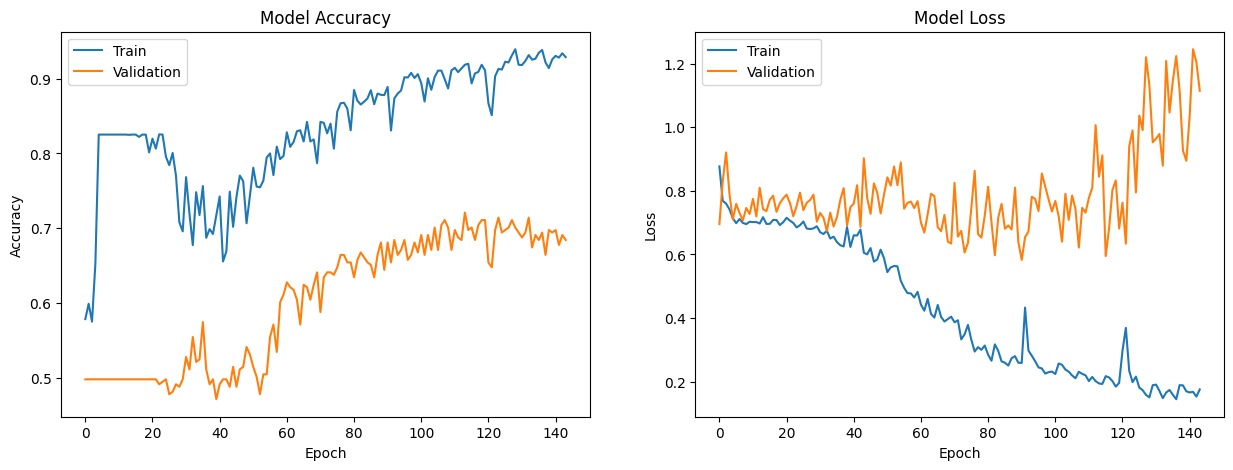


Calculating key performance metrics...
Matthews Correlation Coefficient: 0.4294
Cohen's Kappa Score: 0.4284
AUC-ROC Score: 0.7966

Classification Report:
              precision    recall  f1-score   support

           0     0.7286    0.6800    0.7034       150
           1     0.7019    0.7483    0.7244       151

    accuracy                         0.7143       301
   macro avg     0.7152    0.7142    0.7139       301
weighted avg     0.7152    0.7143    0.7139       301


Plotting Confusion Matrix...


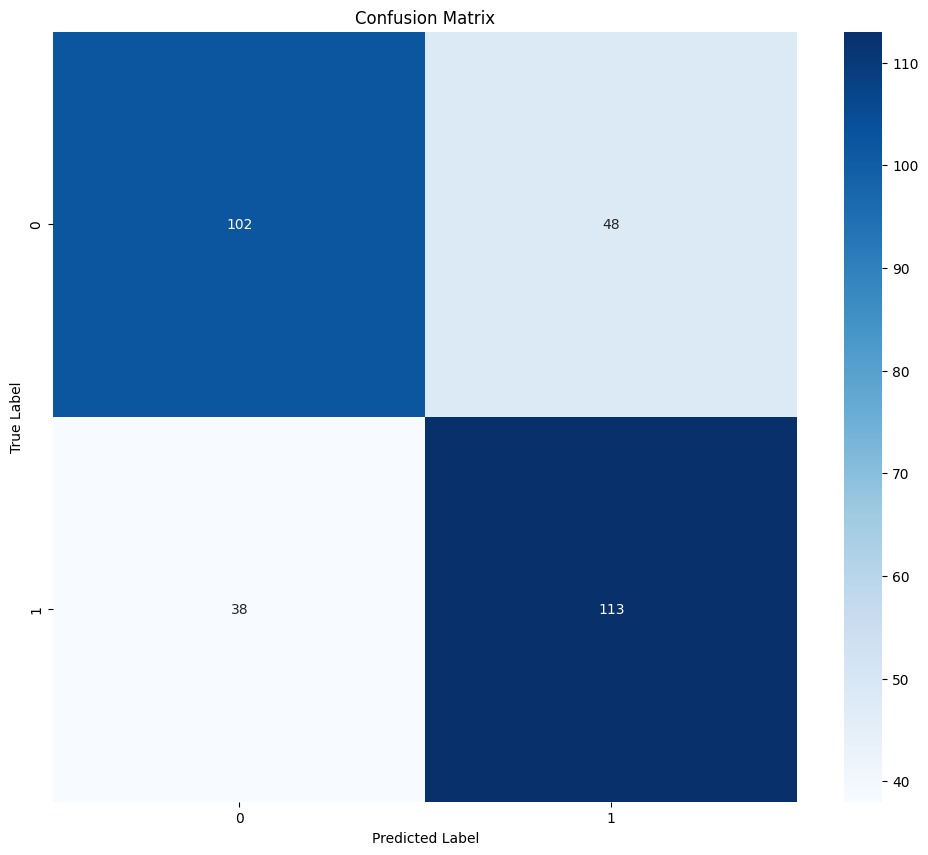


Plotting ROC Curves...


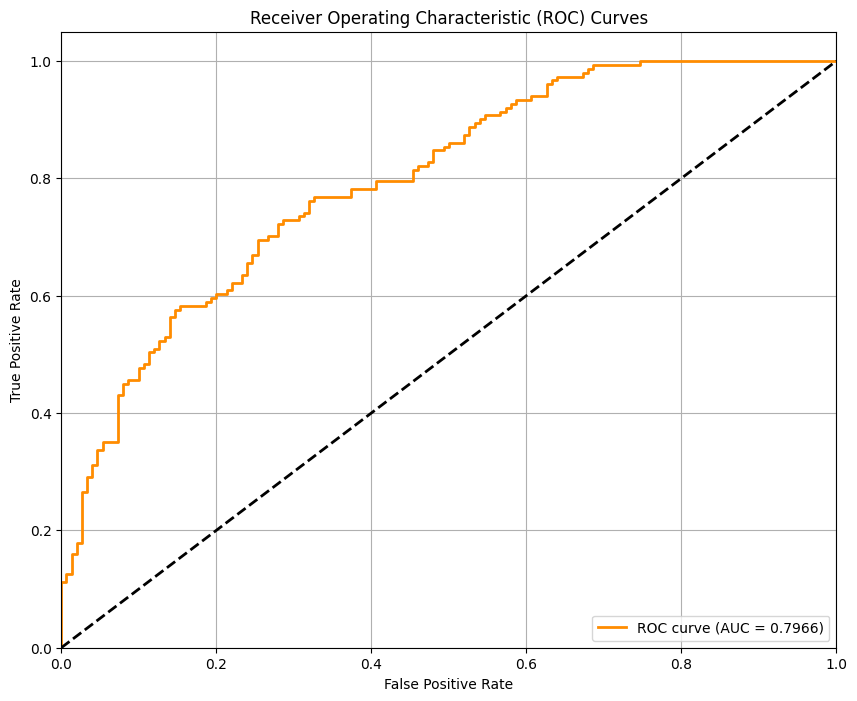

In [ ]:
# ===================================================================
# Block 7: Comprehensive Evaluation
# ===================================================================
from sklearn.preprocessing import label_binarize
from itertools import cycle

# --- Loading the best model ---
print("\nLoading best model for final evaluation...")
best_model = keras.models.load_model(
    checkpoint_filepath,
    custom_objects={'PatchEmbed': PatchEmbed}
)

# --- Getting predictions on the validation set ---
y_true = np.concatenate([y for x, y in val_ds], axis=0).astype(int)
predictions = best_model.predict(val_ds)

# --- Processing predictions based on the task ---
if NUM_CLASSES == 2:
    y_prob = tf.nn.sigmoid(predictions).numpy()
    y_pred = (y_prob > 0.5).astype(int)
else:
    y_prob = predictions # Softmax already outputs probabilities
    y_pred = np.argmax(y_prob, axis=1)

# ===================================================================
# 1. Plotting Training History (Loss and Accuracy Curves)
# ===================================================================
print("\nPlotting training and validation history...")
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plotting training & validation accuracy values
ax1.plot(history.history['accuracy'])
ax1.plot(history.history['val_accuracy'])
ax1.set_title('Model Accuracy')
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Epoch')
ax1.legend(['Train', 'Validation'], loc='upper left')

# Plotting training & validation loss values
ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
ax2.set_title('Model Loss')
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epoch')
ax2.legend(['Train', 'Validation'], loc='upper left')

plt.show()

# ===================================================================
# 2. Key Performance Metrics
# ===================================================================
print("\nCalculating key performance metrics...")

# --- Matthews Correlation Coefficient and Cohen's Kappa ---
mcc = matthews_corrcoef(y_true, y_pred)
kappa = cohen_kappa_score(y_true, y_pred)
print(f"Matthews Correlation Coefficient: {mcc:.4f}")
print(f"Cohen's Kappa Score: {kappa:.4f}")

# --- AUC-ROC Scores (for both binary and multi-class) ---
if NUM_CLASSES == 2:
    auc_roc = roc_auc_score(y_true, y_prob)
    print(f"AUC-ROC Score: {auc_roc:.4f}")
else:
    # Using One-vs-Rest for multi-class AUC
    auc_roc_macro = roc_auc_score(y_true, y_prob, multi_class='ovr', average='macro')
    auc_roc_weighted = roc_auc_score(y_true, y_prob, multi_class='ovr', average='weighted')
    print(f"AUC-ROC (Macro Average): {auc_roc_macro:.4f}")
    print(f"AUC-ROC (Weighted Average): {auc_roc_weighted:.4f}")

# ===================================================================
# 3. Classification Report & Confusion Matrix
# ===================================================================
print("\nClassification Report:")
# Generating class names for the report if they exist.
try:
    class_names = [name for name, index in sorted(class_to_id.items(), key=lambda item: item[1])]
    print(classification_report(y_true, y_pred, target_names=class_names, digits=4))
except NameError:
    # Fallback if class_names aren't defined
    print(classification_report(y_true, y_pred, digits=4))


print("\nPlotting Confusion Matrix...")
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names if 'class_names' in locals() else 'auto',
            yticklabels=class_names if 'class_names' in locals() else 'auto')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# ===================================================================
# 4. ROC Curves (for both binary and multi-class)
# ===================================================================
print("\nPlotting ROC Curves...")
plt.figure(figsize=(10, 8))

if NUM_CLASSES == 2:
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {auc_roc:.4f})')
else:
    # Binarizing the labels for multi-class ROC
    y_true_binarized = label_binarize(y_true, classes=range(NUM_CLASSES))

    # Plotting ROC curve for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 'purple', 'brown', 'pink', 'gray', 'olive'])

    for i, color in zip(range(NUM_CLASSES), colors):
        fpr[i], tpr[i], _ = roc_curve(y_true_binarized[:, i], y_prob[:, i])
        roc_auc[i] = roc_auc_score(y_true_binarized[:, i], y_prob[:, i])
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label=f'ROC curve of class {i} (AUC = {roc_auc[i]:.4f})')

# Plotting the diagonal line
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

## **XAI & Attention Rollout**

Setting up Explainable AI components for the Spectrogram-Only model...
Created explainer model with 6 attention outputs.
--------------------------------------------------
Explaining Sample 1: True Label = 1, Predicted Label = 1


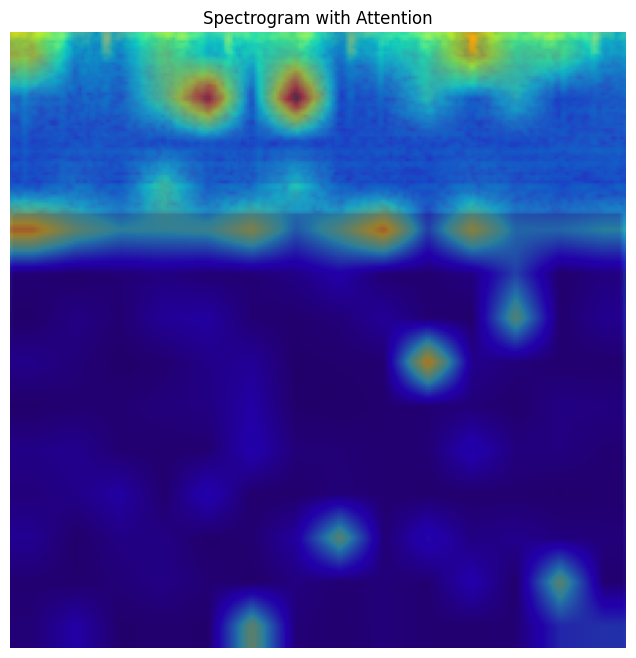

--------------------------------------------------
Explaining Sample 2: True Label = 1, Predicted Label = 0


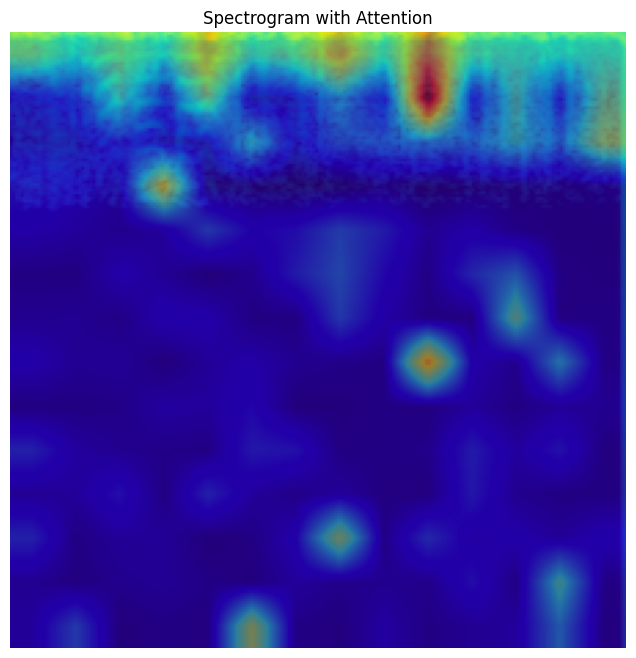

In [ ]:
# ===================================================================
# Block 8: Explainable AI (XAI) for Spectrogram-Only Model
# ===================================================================
import cv2
from tqdm.notebook import tqdm

print("Setting up Explainable AI components for the Spectrogram-Only model...")

# --- Part 1: Rebuilding the Model to Output Attention Scores ---
# This function is now simplified for a single input stream.
def create_explainer_model(num_classes):
    inputs = layers.Input(shape=(CONFIG.IMG_SIZE, CONFIG.IMG_SIZE, CONFIG.IN_CHANS), name="spectrogram_input")
    patches = PatchEmbed(CONFIG.PATCH_SIZE, CONFIG.PROJECTION_DIM)(inputs)
    num_patches = (CONFIG.IMG_SIZE // CONFIG.PATCH_SIZE) ** 2
    pos_embedding_layer = layers.Embedding(input_dim=num_patches, output_dim=CONFIG.PROJECTION_DIM)
    positions = tf.range(start=0, limit=num_patches, delta=1)
    encoded_patches = patches + pos_embedding_layer(positions)
    encoded_patches = layers.Dropout(CONFIG.DROPOUT_RATE)(encoded_patches)

    attention_outputs = []
    for _ in range(CONFIG.TRANSFORMER_LAYERS):
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        attn_layer = layers.MultiHeadAttention(num_heads=CONFIG.NUM_HEADS, key_dim=CONFIG.PROJECTION_DIM // CONFIG.NUM_HEADS, dropout=CONFIG.DROPOUT_RATE)
        attention_output, attention_scores = attn_layer(x1, x1, return_attention_scores=True)
        attention_outputs.append(attention_scores) # Save the scores
        x2 = layers.Add()([attention_output, encoded_patches])
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        for units in CONFIG.MLP_UNITS:
            x3 = layers.Dense(units, activation=tf.nn.gelu)(x3)
            x3 = layers.Dropout(CONFIG.DROPOUT_RATE)(x3)
        x4 = layers.Add()([x3, x2])
        encoded_patches = layers.Dropout(CONFIG.DROPOUT_RATE)(x4)

    return keras.Model(inputs=inputs, outputs=attention_outputs)

explainer_model = create_explainer_model(num_classes=NUM_CLASSES)
explainer_model.load_weights(checkpoint_filepath)
print(f"Created explainer model with {len(explainer_model.outputs)} attention outputs.")


# --- Part 2: Attention Rollout Algorithm ---
def compute_attention_rollout(attention_scores_list):
    num_patches = attention_scores_list[0].shape[-1]
    rollout = np.eye(num_patches, num_patches)
    for attention_map_batch in attention_scores_list:
        attention_map = attention_map_batch[0]
        avg_head_map = np.mean(attention_map, axis=0)
        residual_map = avg_head_map + np.eye(avg_head_map.shape[0])
        residual_map = residual_map / residual_map.sum(axis=-1, keepdims=True)
        rollout = np.matmul(residual_map, rollout)
    return rollout

# --- Part 3: Visualization Function ---
def plot_explanation(sample_image, attention_rollout_map):
    spec_img = sample_image[0].numpy()
    patch_importance = attention_rollout_map.mean(axis=0)
    num_patches_side = int(np.sqrt(len(patch_importance)))
    heatmap = patch_importance.reshape(num_patches_side, num_patches_side)
    heatmap_resized = cv2.resize(heatmap / heatmap.max(), (CONFIG.IMG_SIZE, CONFIG.IMG_SIZE))

    plt.figure(figsize=(8, 8))
    plt.imshow(spec_img, cmap='viridis')
    plt.imshow(heatmap_resized, cmap='jet', alpha=0.5)
    plt.title("Spectrogram with Attention")
    plt.axis('off')
    plt.show()

# --- Part 4: Generating Explanations ---
for i, (image, label) in enumerate(val_ds.take(3)):
    pred = best_model.predict_on_batch(image)

    if NUM_CLASSES == 2:
        pred_label = 1 if tf.nn.sigmoid(pred).numpy().flatten()[0] > 0.5 else 0
    else:
        pred_label = np.argmax(pred[0])

    true_label = int(label[0].numpy())

    print("-" * 50)
    print(f"Explaining Sample {i+1}: True Label = {true_label}, Predicted Label = {pred_label}")

    # Passing the 'image' tensor directly to the explainer.
    attention_scores = explainer_model.predict_on_batch(image)
    rollout_map = compute_attention_rollout(attention_scores)

    # Passing the 'image' tensor directly to the plotting function.
    plot_explanation(image, rollout_map)

# **Waveform Only Baseline**

## **Data Pipeline**

In [ ]:
# ================================================================
# Block 4: Fast Data Pipeline (Waveform-Only)
# ================================================================

# --- Ensuring WAV file paths are present and correct ---
assert 'filepath' in train_df.columns, "The 'filepath' column (for .wav files) is missing from the training metadata."
assert os.path.exists(train_df.iloc[0]['filepath']), f"Could not find WAV file at {train_df.iloc[0]['filepath']}. Did you unzip the original dataset?"

WAVEFORM_MAX_LEN = int(CONFIG.WAVEFORM_LENGTH_SECONDS * 22050)

# --- This function now only loads the waveform ---
def load_wav_only(wav_path, label):
    def _load_wav(path):
        # Importing necessary libraries INSIDE the function for parallel execution
        import librosa
        import numpy as np

        path_str = path.numpy().decode('utf-8')
        wav, _ = librosa.load(path_str, sr=22050, mono=True)

        # Padding or truncating to a fixed length
        if len(wav) > WAVEFORM_MAX_LEN:
            wav = wav[:WAVEFORM_MAX_LEN]
        else:
            wav = np.pad(wav, (0, WAVEFORM_MAX_LEN - len(wav)), 'constant')
        return wav

    [waveform] = tf.py_function(_load_wav, [wav_path], [tf.float32])
    waveform.set_shape([WAVEFORM_MAX_LEN])
    label.set_shape([])

    # Returning a simple (waveform, label) tuple
    return waveform, label

# --- Creating the tf.data.Dataset objects using the new function ---
def create_wav_dataset(df):
    # We now only need the original 'filepath' and 'label' columns
    dataset = tf.data.Dataset.from_tensor_slices((df['filepath'].values, df['label'].values))
    dataset = dataset.map(load_wav_only, num_parallel_calls=tf.data.AUTOTUNE)
    return dataset

def configure_for_performance(ds, shuffle=False):
    if shuffle:
        ds = ds.shuffle(buffer_size=1000)
    ds = ds.repeat()
    ds = ds.batch(CONFIG.BATCH_SIZE)
    ds = ds.prefetch(buffer_size=tf.data.AUTOTUNE)
    return ds

train_ds = configure_for_performance(create_wav_dataset(train_df), shuffle=True)
val_ds = configure_for_performance(create_wav_dataset(val_df))

print("\nWaveform-Only Data pipeline ready.")

# Verifying the output shape of a batch
for waveform, labels in train_ds.take(1):
    print(f"Waveform batch shape: {waveform.shape}")
    print(f"Labels batch shape: {labels.shape}")


Waveform-Only Data pipeline ready.
Waveform batch shape: (256, 110250)
Labels batch shape: (256,)


## **Model Building**

In [ ]:
# ================================================================
# Block 5: Model Building (Waveform-Only CNN)
# ================================================================

def create_waveform_cnn(num_classes):
    """
    Here, I'm building a standalone CNN for waveform classification, identical to the
    waveform branch of the hybrid fusion model.
    """
    # --- 1. Defining a single input for the raw waveform ---
    wave_input = layers.Input(shape=(WAVEFORM_MAX_LEN,), name="wave_input")

    # --- 2. The 1D Waveform CNN Branch ---
    # Reshaping waveform to add a "channels" dimension for Conv1D
    wave_reshaped = layers.Reshape((-1, 1))(wave_input)

    x_1d = layers.Conv1D(64, kernel_size=16, strides=4, activation='relu', padding='same')(wave_reshaped)
    x_1d = layers.BatchNormalization()(x_1d)
    x_1d = layers.MaxPooling1D(pool_size=4)(x_1d)

    x_1d = layers.Conv1D(128, kernel_size=16, strides=4, activation='relu', padding='same')(x_1d)
    x_1d = layers.BatchNormalization()(x_1d)
    x_1d = layers.MaxPooling1D(pool_size=4)(x_1d)

    x_1d = layers.Conv1D(256, kernel_size=16, strides=4, activation='relu', padding='same')(x_1d)
    x_1d = layers.BatchNormalization()(x_1d)

    wave_pooled = layers.GlobalAveragePooling1D()(x_1d)

    # --- 3. The Classifier Head ---
    # The "Funnel Head" from the hybrid model now serves as the pre-classifier feature extractor
    wave_features = layers.Dense(64, activation='relu', name="waveform_funnel")(wave_pooled)
    x = layers.Dropout(0.5)(wave_features) # Adding dropout for regularization

    # Final output layer
    if num_classes == 2:
        output_activation, output_units = None, 1
    else:
        output_activation, output_units = "softmax", num_classes

    outputs = layers.Dense(output_units, activation=output_activation, dtype='float32', name="predictions")(x)

    model = keras.Model(inputs=wave_input, outputs=outputs)
    return model

# --- Instantiating the new model ---
NUM_CLASSES = train_df['label'].nunique()
model = create_waveform_cnn(num_classes=NUM_CLASSES)
model.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ wave_input (InputLayer)         │ (None, 110250)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_22 (Reshape)            │ (None, 110250, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 27563, 64)      │         1,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 27563, 64)      │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 6890, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 1723, 128)      │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 1723, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 430, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 108, 256)       │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 108, 256)       │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_1      │ (None, 256)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ waveform_funnel (Dense)         │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_49 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ predictions (Dense)             │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 675,137 (2.58 MB)

 Trainable params: 674,241 (2.57 MB)

 Non-trainable params: 896 (3.50 KB)

## **Training**

In [ ]:
# ================================================================
# Block 6: Model Training
# ================================================================

# --- Selecting Loss and Metrics ---
if NUM_CLASSES == 2:
    loss = keras.losses.BinaryCrossentropy(from_logits=True)
    metrics = [keras.metrics.BinaryAccuracy(name="accuracy"), keras.metrics.AUC(name="auc")]
else:
    loss = keras.losses.SparseCategoricalCrossentropy()
    metrics = [keras.metrics.SparseCategoricalAccuracy(name="accuracy")]

# --- Compiling the model ---
optimizer = tf.keras.optimizers.AdamW(
    learning_rate=CONFIG.LEARNING_RATE, weight_decay=CONFIG.WEIGHT_DECAY
)
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

# --- Defining Callbacks ---
checkpoint_filepath = "best_model_waveform_baseline.keras"
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True
)
early_stopping_callback = keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=30,
    restore_best_weights=True
)

# --- Defining steps for training ---
steps_per_epoch = len(train_df) // CONFIG.BATCH_SIZE
validation_steps = len(val_df) // CONFIG.BATCH_SIZE
print(f"\nTraining with {steps_per_epoch} steps per epoch and {validation_steps} validation steps.")

# --- Training the model ---
print("\nStarting model training...")
history = model.fit(
    train_ds,
    epochs=CONFIG.EPOCHS,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_ds,
    validation_steps=validation_steps,
    callbacks=[model_checkpoint_callback, early_stopping_callback],
    class_weight=class_weight_dict
)
print("Training complete.")


Training with 11 steps per epoch and 1 validation steps.

Starting model training...
Epoch 1/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 20s 692ms/step - accuracy: 0.8662 - auc: 0.8918 - loss: 0.3500 - val_accuracy: 0.5430 - val_auc: 0.5000 - val_loss: 0.7267
Epoch 2/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 210ms/step - accuracy: 0.8377 - auc: 0.8748 - loss: 0.4106 - val_accuracy: 0.5430 - val_auc: 0.4998 - val_loss: 0.7014
Epoch 3/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 561ms/step - accuracy: 0.8712 - auc: 0.8937 - loss: 0.3354 - val_accuracy: 0.5430 - val_auc: 0.5043 - val_loss: 0.6948
Epoch 4/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 7s 673ms/step - accuracy: 0.8602 - auc: 0.8674 - loss: 0.3787 - val_accuracy: 0.5430 - val_auc: 0.5043 - val_loss: 0.6960
Epoch 5/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 7s 671ms/step - accuracy: 0.8652 - auc: 0.8838 - loss: 0.3441 - val_accuracy: 0.5430 - val_auc: 0.5043 - val_loss: 0.6896
Epoch 6/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.8763 - auc: 0.8793 - loss: 0.3449 - val_acc

## **Evaluation**


Loading best model for final evaluation...
Creating a finite validation dataset for evaluation...
Generating predictions on the validation set...
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 701ms/step

Plotting training and validation history...


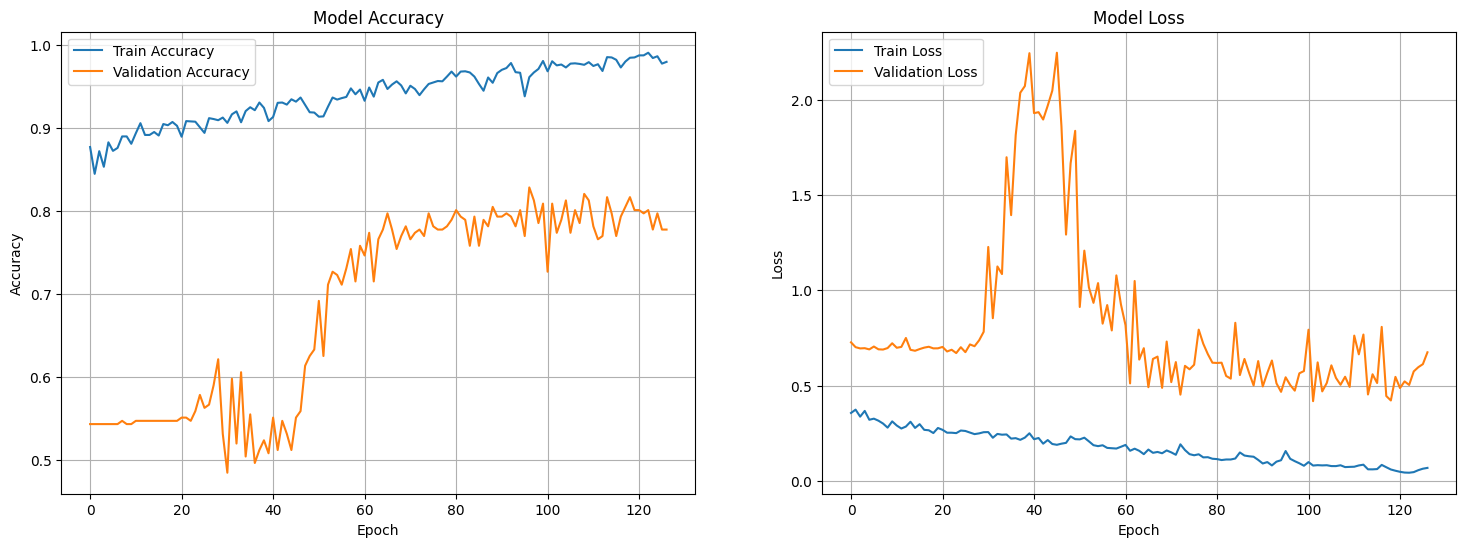


Calculating key performance metrics...
Matthews Correlation Coefficient: 0.4944
Cohen's Kappa Score: 0.4886
AUC-ROC Score: 0.8444

Classification Report:
              precision    recall  f1-score   support

      Normal     0.7110    0.8200    0.7616       150
    Abnormal     0.7891    0.6689    0.7240       151

    accuracy                         0.7442       301
   macro avg     0.7500    0.7444    0.7428       301
weighted avg     0.7502    0.7442    0.7427       301


Plotting Confusion Matrix...


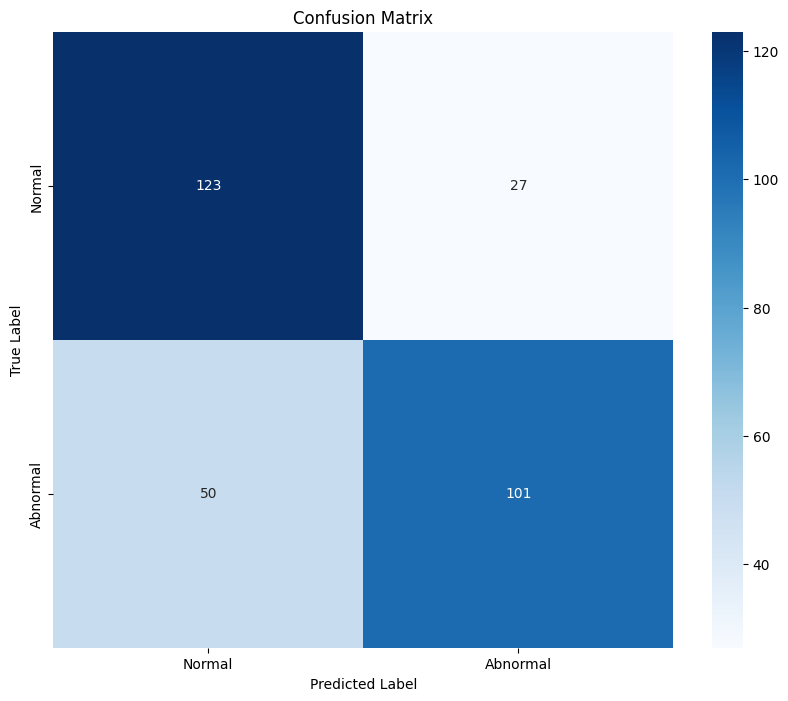


Plotting ROC Curves...


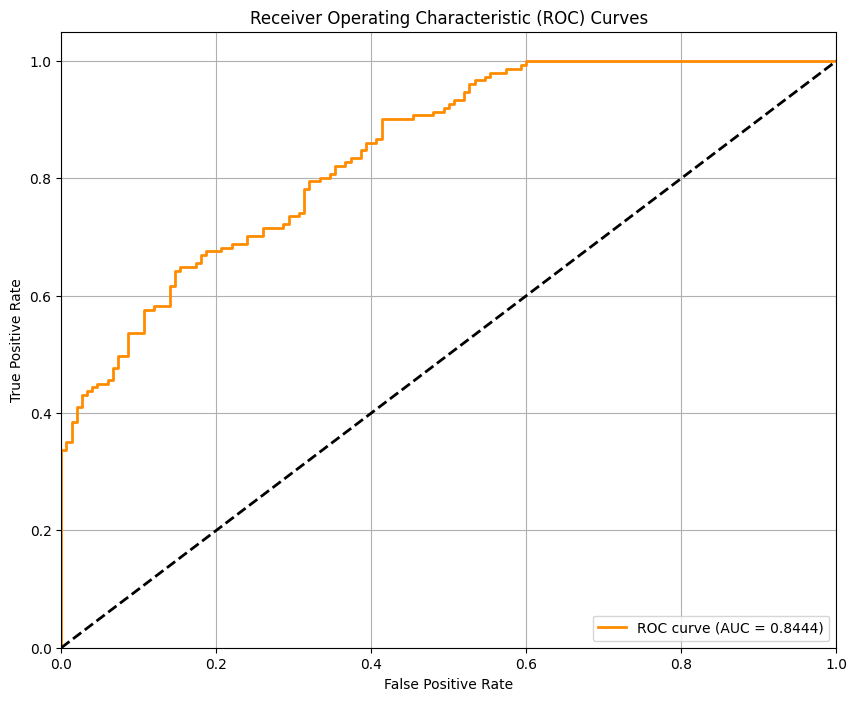

In [ ]:
# ================================================================
# Block 7: Comprehensive Evaluation (Waveform-Only)
# ================================================================
from sklearn.preprocessing import label_binarize
from itertools import cycle

# --- Loading the best model ---
print("\nLoading best model for final evaluation...")
best_model = keras.models.load_model(checkpoint_filepath)

# --- Creating a finite, non-repeating validation set for evaluation ---
print("Creating a finite validation dataset for evaluation...")
val_ds_eval = create_wav_dataset(val_df).batch(CONFIG.BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# --- Getting predictions and true labels ---
print("Generating predictions on the validation set...")
y_prob = best_model.predict(val_ds_eval)
y_true = val_df['label'].values
if NUM_CLASSES == 2:
    y_pred = (tf.nn.sigmoid(y_prob).numpy().flatten() > 0.5).astype(int)
else:
    y_pred = np.argmax(y_prob, axis=1)

# ===================================================================
# 1. Plotting Training History (Loss and Accuracy Curves)
# ===================================================================
print("\nPlotting training and validation history...")
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

ax1.plot(history.history['accuracy'], label='Train Accuracy')
ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_title('Model Accuracy')
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Epoch')
ax1.legend(loc='upper left')
ax1.grid(True)

ax2.plot(history.history['loss'], label='Train Loss')
ax2.plot(history.history['val_loss'], label='Validation Loss')
ax2.set_title('Model Loss')
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epoch')
ax2.legend(loc='upper left')
ax2.grid(True)

plt.show()

# ===================================================================
# 2. Key Performance Metrics
# ===================================================================
print("\nCalculating key performance metrics...")
mcc = matthews_corrcoef(y_true, y_pred)
kappa = cohen_kappa_score(y_true, y_pred)
print(f"Matthews Correlation Coefficient: {mcc:.4f}")
print(f"Cohen's Kappa Score: {kappa:.4f}")

if NUM_CLASSES == 2:
    auc_roc = roc_auc_score(y_true, y_prob)
    print(f"AUC-ROC Score: {auc_roc:.4f}")
else:
    auc_roc_macro = roc_auc_score(y_true, y_prob, multi_class='ovr', average='macro')
    print(f"AUC-ROC (Macro Average): {auc_roc_macro:.4f}")

# ===================================================================
# 3. Classification Report & Confusion Matrix
# ===================================================================
print("\nClassification Report:")
class_names = ['Normal', 'Abnormal'] if NUM_CLASSES == 2 else [f'Class {i}' for i in range(NUM_CLASSES)]
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

print("\nPlotting Confusion Matrix...")
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# ===================================================================
# 4. ROC Curves
# ===================================================================
print("\nPlotting ROC Curves...")
plt.figure(figsize=(10, 8))

if NUM_CLASSES == 2:
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {auc_roc:.4f})')
else:
    y_true_binarized = label_binarize(y_true, classes=range(NUM_CLASSES))
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 'purple', 'brown', 'pink', 'gray', 'olive'])
    for i, color in zip(range(NUM_CLASSES), colors):
        fpr, tpr, _ = roc_curve(y_true_binarized[:, i], y_prob[:, i])
        roc_auc = roc_auc_score(y_true_binarized[:, i], y_prob[:, i])
        plt.plot(fpr, tpr, color=color, lw=2,
                 label=f'ROC curve of class {i} (AUC = {roc_auc:.4f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

## **XAI**

Waveform CNN explainer will use layer: conv1d_5

--- Explaining 3 Random Samples ---
--------------------------------------------------
Explaining Sample 1 (File: e00477.wav)
True Label: 1, Predicted Label: 1


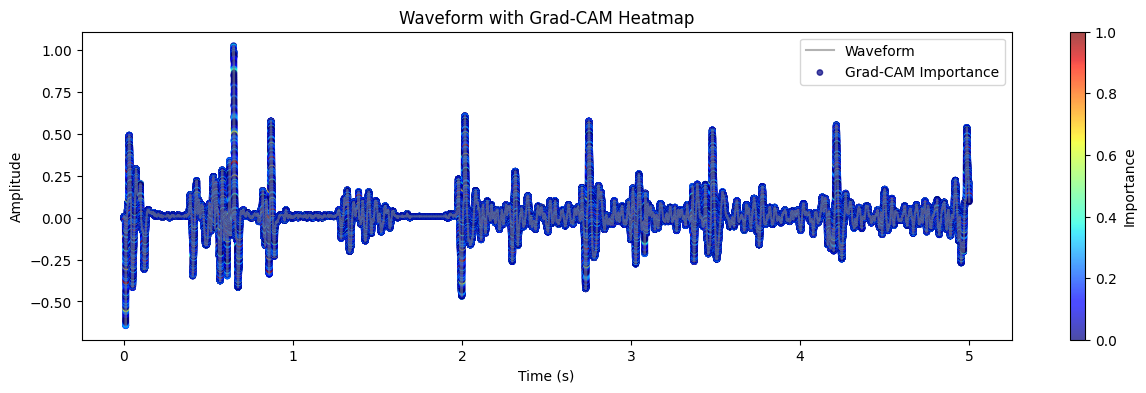

--------------------------------------------------
Explaining Sample 2 (File: b0197.wav)
True Label: 1, Predicted Label: 0


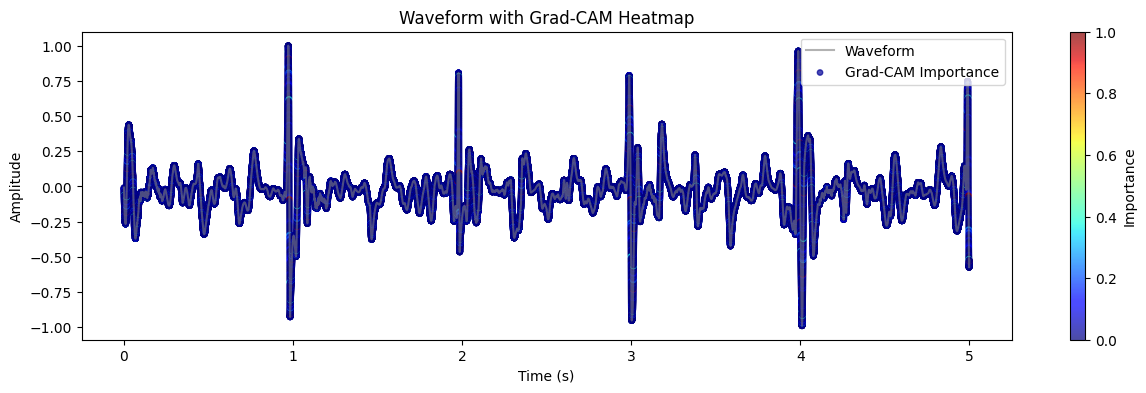

--------------------------------------------------
Explaining Sample 3 (File: b0026.wav)
True Label: 0, Predicted Label: 0


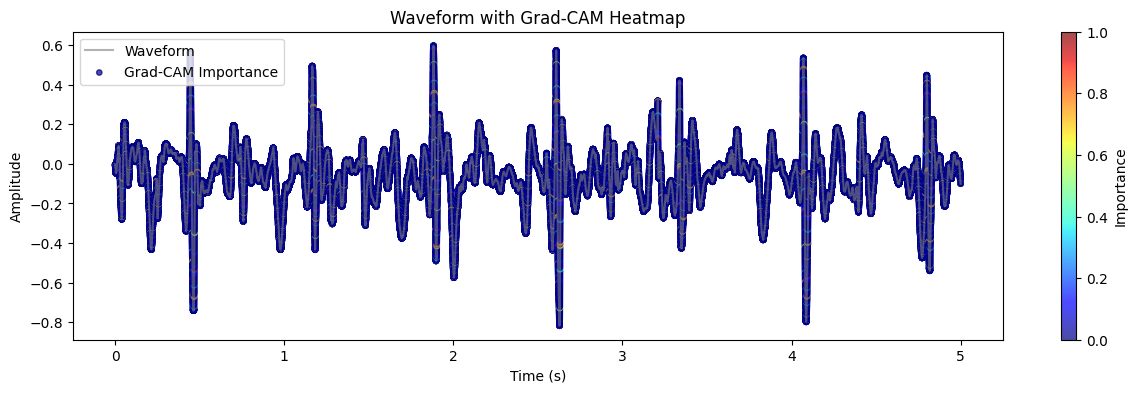

In [ ]:
# ================================================================
# Block 8: Explainable AI with Waveform CNN
# ================================================================
import cv2
import librosa

# --- Grad-CAM and plotting functions ---
def make_gradcam_heatmap_1d_standalone(waveform_array, model, last_conv_layer_name, pred_index=None):
    grad_model = keras.models.Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(waveform_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]
    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1))
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / (tf.math.reduce_max(heatmap) + 1e-6)
    return heatmap.numpy()

def plot_waveform_gradcam(waveform_sample, heatmap):
    fig, ax = plt.subplots(figsize=(15, 4))
    waveform_to_plot = waveform_sample[0].numpy()
    time_axis = np.arange(len(waveform_to_plot)) / 22050.0
    heatmap_resized = np.resize(heatmap, waveform_to_plot.shape)
    ax.plot(time_axis, waveform_to_plot, color='gray', alpha=0.6, label='Waveform')
    scatter = ax.scatter(time_axis, waveform_to_plot, c=heatmap_resized, cmap='jet', s=15, alpha=0.7, label='Grad-CAM Importance')
    ax.set_title("Waveform with Grad-CAM Heatmap")
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Amplitude")
    fig.colorbar(scatter, ax=ax, label='Importance')
    ax.legend()
    plt.show()

# --- Finding the last convolutional layer in our model ---
last_conv_layer_name_1d = [l.name for l in best_model.layers if isinstance(l, layers.Conv1D)][-1]
print(f"Waveform CNN explainer will use layer: {last_conv_layer_name_1d}")

# --- Generating explanations for a few RANDOM samples ---
# We are randomly sampling 3 rows from our validation DataFrame
num_samples_to_explain = 3
random_samples_df = val_df.sample(n=num_samples_to_explain, random_state=CONFIG.RANDOM_STATE)

print(f"\n--- Explaining {num_samples_to_explain} Random Samples ---")

for i, row in enumerate(random_samples_df.itertuples()):
    wav_path = row.filepath
    true_label = row.label

    # --- Manually loading and processing the single waveform ---
    wav, _ = librosa.load(wav_path, sr=22050, mono=True)
    if len(wav) > WAVEFORM_MAX_LEN:
        wav = wav[:WAVEFORM_MAX_LEN]
    else:
        wav = np.pad(wav, (0, WAVEFORM_MAX_LEN - len(wav)), 'constant')

    # Converting to a tensor and adding a batch dimension of 1
    waveform_tensor = tf.convert_to_tensor(wav, dtype=tf.float32)[tf.newaxis, :]

    # --- Getting model prediction for this single sample ---
    pred = best_model.predict(waveform_tensor, verbose=0)
    if NUM_CLASSES == 2:
        pred_label = (tf.nn.sigmoid(pred).numpy().flatten()[0] > 0.5).astype(int)
    else:
        pred_label = np.argmax(pred[0])

    print("-" * 50)
    print(f"Explaining Sample {i+1} (File: {os.path.basename(wav_path)})")
    print(f"True Label: {true_label}, Predicted Label: {pred_label}")

    # Generating the heatmap
    heatmap = make_gradcam_heatmap_1d_standalone(waveform_tensor, best_model, last_conv_layer_name_1d)

    # Displaying the superimposed image
    plot_waveform_gradcam(waveform_tensor, heatmap)